In [100]:
import nibabel as nib
import numpy as np
import os
import warnings

labs = True
if labs:
    # Define the path to the tractograms to evaluate
    results_path = "/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0"
else:
    results_path = "/mnt/d/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0"

# Get the streamlines
optimized_path = os.path.join(results_path, "track.trk")
model_path = os.path.join(results_path, "tracer_decoded_restored.trk")
original_path = os.path.join(results_path, "tracer_streamlines_restored.trk")

# Get the atlas label paths
MBCA_labels_path = os.path.join(results_path, "MBCA_labels.txt")
MBM_labels_path = os.path.join(results_path, "MBM_cortex_labels.txt")

# Possibility to stop warnings
warnings.filterwarnings('ignore') 

## **Load Labels for Atlas**

In [101]:
# Dictionary to store the results
MBCA_label_data = {}
MBM_label_data = {}

# Load data from MBCA and MBM
with open(MBCA_labels_path, 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.strip().split("\t") 
        # Extract the first column (assuming it's a number) and the last column (label)
        number = float(columns[0])
        label = columns[-1].strip('"')

        # Save to dictionary
        MBCA_label_data[number] = label
    
# Load the data from MBM
with open(MBM_labels_path, 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.strip().split() 
        # Extract the first column (assuming it's a number) and the last column (label)
        number = float(columns[-1])
        label = columns[0]

        # Save to dictionary
        MBM_label_data[number] = label

# Print the number of labels
print("Number of labels in MBCA: {}".format(len(MBCA_label_data)))
print("Number of labels in MBM: {}".format(len(MBM_label_data)))

Number of labels in MBCA: 139
Number of labels in MBM: 54


## **Create Connectomes**

In [102]:
import glob

# Retrieve (GLOB) files
def glob_files(PATH_NAME, file_format):
    INPUT_FILES = []
    for file in glob.glob(os.path.join(PATH_NAME, os.path.join("**", "*.{}".format(file_format))), recursive=True):
        INPUT_FILES.append(file)
    return INPUT_FILES

# Load all csv files in results_path
csv_files = glob_files(results_path, "csv")

# Separate to model, optimized and tracer
model_csv = [file for file in csv_files if "model" in file]
optimized_csv = [file for file in csv_files if "optimized" in file]
tracer_csv = [file for file in csv_files if "tracer" in file]

In [103]:
# Function to create the dictionary and load the csv files
def load_csv(csv_files):
    
    # Create a dictionary
    csv_dict = {}

    # Loop over each csv file
    for file in csv_files:
        # Extract the atlas name
        atlas_name = file.split(os.sep)[-1].replace(".csv", "").split("_")[-1]
        # Add the atlas name and csv file to the dictionary
        csv_dict[atlas_name] = file

    # Return the dictionary
    return csv_dict

model_csv_dict = load_csv(model_csv)
optimized_csv_dict = load_csv(optimized_csv)
tracer_csv_dict = load_csv(tracer_csv)

print("Model csv dictionary: {}".format(model_csv_dict))
print("Optimized csv dictionary: {}".format(optimized_csv_dict))
print("Tracer csv dictionary: {}".format(tracer_csv_dict))

Model csv dictionary: {'MBCA': '/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0/model_MBCA.csv', 'MBM': '/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0/model_MBM.csv'}
Optimized csv dictionary: {'MBCA': '/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0/optimized_MBCA.csv', 'MBM': '/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0/optimized_MBM.csv'}
Tracer csv dictionary: {'MBCA': '/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0/tracer_MBCA.csv', 'MBM': '/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0/tracer_MBM.csv'}


In [104]:
# Function to flip the matrix
def flip_matrix(matrix):

    # Flip the matrix
    flipped_matrix = np.flip(matrix, axis=0)

    # Flip the matrix again
    flipped_matrix = np.flip(flipped_matrix, axis=1)

    # Add the original to the flipped
    flipped_matrix = flipped_matrix + matrix

    # Return the flipped matrix
    return flipped_matrix

# Function to load the connectomes
def load_connectomes(csv_dict):

    # Create a dictionary
    connectomes = {}
    symmetrized_connectomes = {}

    # Loop over each csv file
    for atlas_name, file in csv_dict.items():
        # Read the csv file
        connectome = np.genfromtxt(file, delimiter=',')
        # Log the connectome
        connectomes[atlas_name] = np.log(connectome + 1)
        # Symmetrize the connectome
        symmetrized_connectomes[atlas_name] = flip_matrix(connectomes[atlas_name])
        # Print the shape of the connectome
        print("Connectome shape for {}: {}".format(atlas_name, connectomes[atlas_name].shape))

    # Return the dictionary
    return connectomes, symmetrized_connectomes

model_connectomes, model_symmetrized_connectomes = load_connectomes(model_csv_dict)
optimized_connectomes, optimized_symmetrized_connectomes = load_connectomes(optimized_csv_dict)
tracer_connectomes, tracer_symmetrized_connectomes = load_connectomes(tracer_csv_dict)

Connectome shape for MBCA: (135, 135)
Connectome shape for MBM: (54, 54)
Connectome shape for MBCA: (135, 135)
Connectome shape for MBM: (54, 54)
Connectome shape for MBCA: (135, 135)
Connectome shape for MBM: (54, 54)


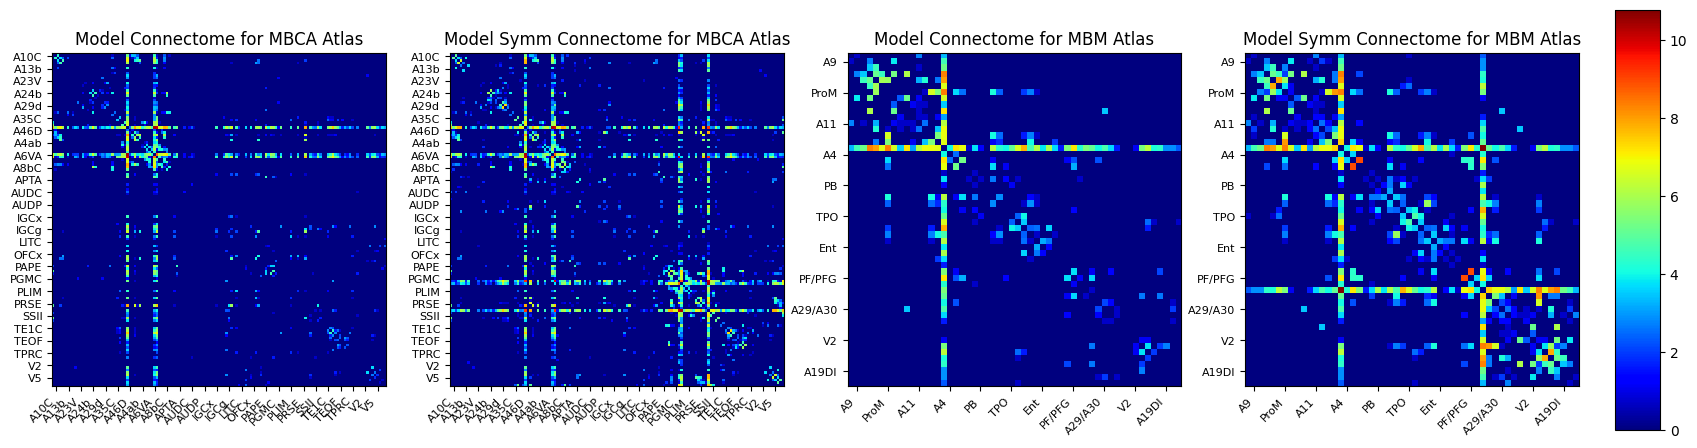

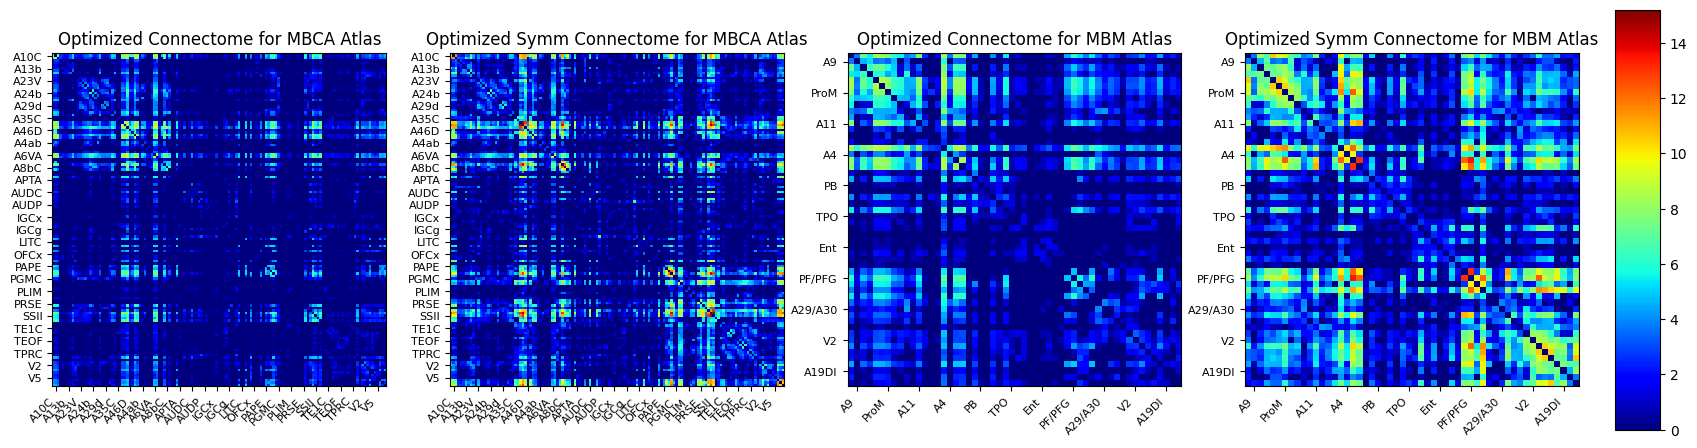

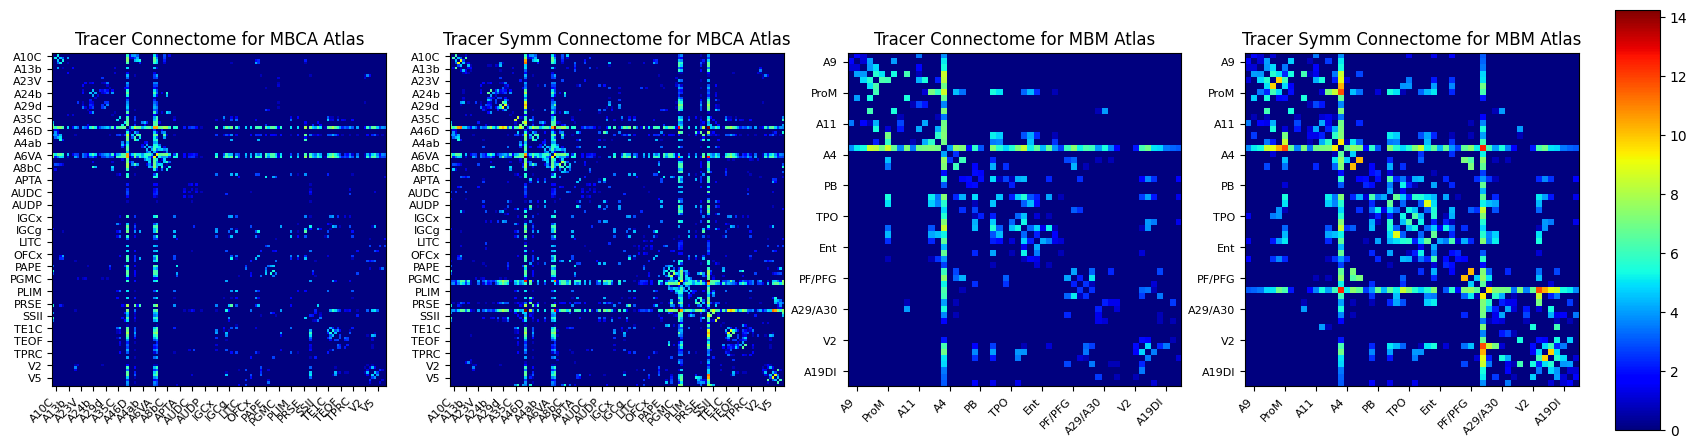

In [105]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def plot_connectomes_row(atlas_name, connectome_data, symmetrized_connectome_data, title_prefix, MBCA_labels_data, MBM_labels_data):
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))

    # Determine shared colormap normalization across plots for consistent visualization within this row
    vmin = min(np.min(connectome_data["MBCA"]), np.min(symmetrized_connectome_data["MBCA"]),
               np.min(connectome_data["MBM"]), np.min(symmetrized_connectome_data["MBM"]))
    vmax = max(np.max(connectome_data["MBCA"]), np.max(symmetrized_connectome_data["MBCA"]),
               np.max(connectome_data["MBM"]), np.max(symmetrized_connectome_data["MBM"]))

    # Helper function to plot images
    def plot_image(ax, data, title, labels_data):
        im = ax.imshow(data, interpolation='nearest', aspect='equal', cmap="jet", vmin=vmin, vmax=vmax)
        ax.set_title(title)
        
        ticks = list(labels_data.keys())
        labels = list(labels_data.values())
        
        # Reduce label density by showing every nth label
        n = 5  # Adjust this value as needed
        visible_ticks = ticks[::n]
        visible_ticks = [int(i) for i in visible_ticks]
        visible_labels = [labels[i] for i in visible_ticks]
        
        # Adjust the rotation angle of tick labels and stagger them
        ax.set_xticks(visible_ticks)
        ax.set_yticks(visible_ticks)
        ax.set_xticklabels(visible_labels, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(visible_labels, fontsize=8)
        
        return im

    # MBCA Atlas
    plot_image(axs[0], connectome_data["MBCA"], f"{title_prefix} Connectome for MBCA Atlas", MBCA_labels_data)
    plot_image(axs[1], symmetrized_connectome_data["MBCA"], f"{title_prefix} Symm Connectome for MBCA Atlas", MBCA_labels_data)

    # MBM Atlas
    plot_image(axs[2], connectome_data["MBM"], f"{title_prefix} Connectome for MBM Atlas", MBM_labels_data)
    last_im = plot_image(axs[3], symmetrized_connectome_data["MBM"], f"{title_prefix} Symm Connectome for MBM Atlas", MBM_labels_data)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(right=0.88)

    # Add colorbar using the last image instance
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
    fig.colorbar(last_im, cax=cbar_ax, orientation='vertical')  # Now, we use 'last_im' for the colorbar.
    plt.show()

# Ensure the label data is only until the same size as the connectome
MBCA_label_data = {k: v for k, v in MBCA_label_data.items() if k <= model_connectomes["MBCA"].shape[0]}
MBM_label_data = {k: v for k, v in MBM_label_data.items() if k <= model_connectomes["MBM"].shape[0]}

# Plot for each model
plot_connectomes_row("MBCA", model_connectomes, model_symmetrized_connectomes, "Model", MBCA_label_data, MBM_label_data)
plot_connectomes_row("MBCA", optimized_connectomes, optimized_symmetrized_connectomes, "Optimized", MBCA_label_data, MBM_label_data)
plot_connectomes_row("MBCA", tracer_connectomes, tracer_symmetrized_connectomes, "Tracer", MBCA_label_data, MBM_label_data)


## **Graph Theory Stuff**

In [106]:
import networkx as nx

# Function to create a graph for every connectome and remove self-loops
def create_graph(connectome_data, symmetrized_connectome_data):

    # Create a dictionary
    graphs = {}
    symm_graphs = {}

    # Loop over each connectome
    for atlas_name, connectome in connectome_data.items():
        # Create a graph
        graph = nx.Graph(connectome)
        # Remove self-loops
        graph.remove_edges_from(nx.selfloop_edges(graph))
        # Add the graph to the dictionary
        graphs[atlas_name] = graph

    # Loop over each symmetrized connectome
    for atlas_name, symmetrized_connectome in symmetrized_connectome_data.items():
        # Create a graph
        graph = nx.Graph(symmetrized_connectome)
        # Remove self-loops
        graph.remove_edges_from(nx.selfloop_edges(graph))
        # Add the graph to the dictionary
        symm_graphs[atlas_name] = graph

    # Return the dictionary
    return graphs, symm_graphs

model_graphs, model_symm_graphs = create_graph(model_connectomes, model_symmetrized_connectomes)
optimized_graphs, optimized_symm_graphs = create_graph(optimized_connectomes, optimized_symmetrized_connectomes)
tracer_graphs, tracer_symm_graphs = create_graph(tracer_connectomes, tracer_symmetrized_connectomes)


#### **Graph Density**
**Defintion**: A graph's density is the ratio between the number of edges and the total number of possible edges.

In [107]:
# Compute the density of the graphs
def compute_density(graphs):

    # Create a dictionary
    density = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the density
        density[atlas_name] = nx.density(graph)

    # Return the dictionary
    return density

# Compute the density of the graphs
model_density = compute_density(model_graphs)
optimized_density = compute_density(optimized_graphs)
tracer_density = compute_density(tracer_graphs)

# Compute the density of the symmetrized graphs
model_symm_density = compute_density(model_symm_graphs)
optimized_symm_density = compute_density(optimized_symm_graphs)
tracer_symm_density = compute_density(tracer_symm_graphs)

# Print the density of the graphs
print("Model density: {}".format(model_density))
print("Optimized density: {}".format(optimized_density))
print("Tracer density: {}".format(tracer_density))

print("----------------------------------------")

print("Model symmetrized density: {}".format(model_symm_density))
print("Optimized symmetrized density: {}".format(optimized_symm_density))
print("Tracer symmetrized density: {}".format(tracer_symm_density))

Model density: {'MBCA': 0.06025428413488115, 'MBM': 0.1111111111111111}
Optimized density: {'MBCA': 0.26235489220563846, 'MBM': 0.5324947589098532}
Tracer density: {'MBCA': 0.07595356550580432, 'MBM': 0.13906359189378056}
----------------------------------------
Model symmetrized density: {'MBCA': 0.11586511885019347, 'MBM': 0.20475192173305382}
Optimized symmetrized density: {'MBCA': 0.4451077943615257, 'MBM': 0.7638015373864431}
Tracer symmetrized density: {'MBCA': 0.14472084024322832, 'MBM': 0.24388539482879107}


#### **Nodal Strength and Degree**
**Defintion**: A graph's density is the ratio between the number of edges and the total number of possible edges.

In [142]:
# Compute the nodal degree and strength of the graphs
def compute_nodal_degree_and_strength(graphs):
    
    nodal_degree = {}
    nodal_strength = {}
    norm_strengths = {}
    mean_degrees = {}
    mean_strengths = {}

    for atlas_name, graph in graphs.items():
        # Compute the degree
        nodal_degree[atlas_name] = dict(graph.degree())

        # Compute the strength, format it as the NB and normalize it
        nodal_strength[atlas_name] = dict(nx.degree(graph, weight="weight"))
        nodal_strength[atlas_name] = {k: v for k, v in nodal_strength[atlas_name].items()}

        # Compute mean degree and strength
        mean_degrees[atlas_name] = np.mean(list(nodal_degree[atlas_name].values()))
        mean_strengths[atlas_name] = np.mean(list(nodal_strength[atlas_name].values()))
        
        # Compute the normalized strength as the strength minus the mean strength
        norm_strengths[atlas_name] = np.array([val - mean_strengths[atlas_name] for node, val in nodal_strength[atlas_name].items()])

        # Add as attributes to the graph with atlas-specific names
        nx.set_node_attributes(graph, nodal_degree[atlas_name], "{}_degree".format(atlas_name))
        nx.set_node_attributes(graph, nodal_strength[atlas_name], "{}_strength".format(atlas_name))
        nx.set_node_attributes(graph, nodal_strength[atlas_name], "{}_strength_normalized".format(atlas_name))

    return nodal_degree, nodal_strength, norm_strengths, mean_degrees, mean_strengths


# Compute the stuff from the function above
(model_nodal_degree, model_nodal_strength, model_nodal_normalized_strength, 
 model_mean_degrees, model_mean_strengths) = compute_nodal_degree_and_strength(model_graphs)
(optimized_nodal_degree, optimized_nodal_strength, optimized_nodal_normalized_strength, 
 optimized_mean_degrees, optimized_mean_strengths) = compute_nodal_degree_and_strength(optimized_graphs)
(tracer_nodal_degree, tracer_nodal_strength, tracer_nodal_normalized_strength,
    tracer_mean_degrees, tracer_mean_strengths) = compute_nodal_degree_and_strength(tracer_graphs)

# Compute the stuff from the function above - symmetrized
(model_symm_nodal_degree, model_symm_nodal_strength, model_symm_nodal_normalized_strength, 
 model_symm_mean_degrees, model_symm_mean_strengths) = compute_nodal_degree_and_strength(model_symm_graphs)
(optimized_symm_nodal_degree, optimized_symm_nodal_strength, optimized_symm_nodal_normalized_strength,
    optimized_symm_mean_degrees, optimized_symm_mean_strengths) = compute_nodal_degree_and_strength(optimized_symm_graphs)
(tracer_symm_nodal_degree, tracer_symm_nodal_strength, tracer_symm_nodal_normalized_strength,
    tracer_symm_mean_degrees, tracer_symm_mean_strengths) = compute_nodal_degree_and_strength(tracer_symm_graphs)

# Print the mean degrees and strengths
print("Model mean degrees: {}".format(model_mean_degrees))
print("Optimized mean degrees: {}".format(optimized_mean_degrees))
print("Tracer mean degrees: {}".format(tracer_mean_degrees))

print("----------------------------------------")

print("Model mean strengths: {}".format(model_mean_strengths))
print("Optimized mean strengths: {}".format(optimized_mean_strengths))
print("Tracer mean strengths: {}".format(tracer_mean_strengths))

Model mean degrees: {'MBCA': 8.074074074074074, 'MBM': 5.888888888888889}
Optimized mean degrees: {'MBCA': 35.15555555555556, 'MBM': 28.22222222222222}
Tracer mean degrees: {'MBCA': 10.177777777777777, 'MBM': 7.37037037037037}
----------------------------------------
Model mean strengths: {'MBCA': 25.110200081430122, 'MBM': 18.531890922708882}
Optimized mean strengths: {'MBCA': 86.19330884523207, 'MBM': 76.62920556424785}
Tracer mean strengths: {'MBCA': 34.28859084580472, 'MBM': 26.194070699807085}


In [109]:
import seaborn as sns

# Defining atlas and colors
atlases = ["MBCA", "MBM"]

alpha = 0.75  # Transparency of the histograms
alpha_grid = 0.35  # Transparency of the grid

# Generate a cubehelix color palette with more contrast
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)  # Adjust dark and light parameters
pinkish = color_palette[2]  # Adjusted index for higher contrast pink
purpleish = color_palette[6]  # Adjusted index for higher contrast purple
inbetween = color_palette[4]  # Keeping the intermediate color

beige_palette = sns.light_palette(color_palette[4], n_colors=10)
beige_color = beige_palette[1]  # Picking a lighter shade from the generated beige palette

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_subplots(data, title_prefix):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(22, 5))

    for idx, atlas in enumerate(atlases):
        
        # Get the data
        model_data = data["Model"][atlas]
        optimized_data = data["Optimized"][atlas]
        tracer_data = data["Tracer"][atlas]
        symm_model_data = data["Symm Model"][atlas]
        symm_optimized_data = data["Symm Optimized"][atlas]
        symm_tracer_data = data["Symm Tracer"][atlas]
        
        # Get the values depending on the type
        if hasattr(model_data, 'values'):
            model_data = model_data.values()
        if hasattr(optimized_data, 'values'):
            optimized_data = optimized_data.values()
        if hasattr(tracer_data, 'values'):
            tracer_data = tracer_data.values()

        if hasattr(symm_model_data, 'values'):
            symm_model_data = symm_model_data.values()
        if hasattr(symm_optimized_data, 'values'):
            symm_optimized_data = symm_optimized_data.values()
        if hasattr(symm_tracer_data, 'values'):
            symm_tracer_data = symm_tracer_data.values()

        # Get the mean and std
        model_mean, model_std = np.mean(np.array(list(model_data))), np.std(np.array(list(model_data)))
        optimized_mean, optimized_std = np.mean(np.array(list(optimized_data))), np.std(np.array(list(optimized_data)))
        tracer_mean, tracer_std = np.mean(np.array(list(tracer_data))), np.std(np.array(list(tracer_data)))
        symm_model_mean, symm_model_std = np.mean(np.array(list(symm_model_data))), np.std(np.array(list(symm_model_data)))
        symm_optimized_mean, symm_optimized_std = np.mean(np.array(list(symm_optimized_data))), np.std(np.array(list(symm_optimized_data)))
        symm_tracer_mean, symm_tracer_std = np.mean(np.array(list(symm_tracer_data))), np.std(np.array(list(symm_tracer_data)))
        
        # Plot the data
        sns.distplot(list(model_data), color=pinkish, label="Model", ax=axes[idx], hist_kws={'alpha': alpha})
        sns.distplot(list(optimized_data), color=inbetween, label="Optimized", ax=axes[idx], hist_kws={'alpha': alpha})
        sns.distplot(list(tracer_data), color=purpleish, label="Tracer", ax=axes[idx], hist_kws={'alpha': alpha})
        sns.distplot(list(symm_model_data), color=pinkish, label="Symm Model", ax=axes[idx + len(atlases)], hist_kws={'alpha': alpha})
        sns.distplot(list(symm_optimized_data), color=inbetween, label="Symm Optimized", ax=axes[idx + len(atlases)], hist_kws={'alpha': alpha})
        sns.distplot(list(symm_tracer_data), color=purpleish, label="Symm Tracer", ax=axes[idx + len(atlases)], hist_kws={'alpha': alpha})
        
        axes[idx].patch.set_facecolor(beige_color)
        axes[idx].legend()
        axes[idx].set_title("{} for {} atlas".format(title_prefix, atlas))
        axes[idx].grid(True, alpha=alpha_grid)
        axes[idx].set_axisbelow(True)

        # Formatting for the text box
        box_format = {'facecolor': 'white', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'}

        # Draw the mean and std as text on the plot (Model, Optimized, Tracer)
        axes[idx].text(0.95, 0.70, "Model\nMean: {:.2f}\nStd: {:.2f}".format(model_mean, model_std),
                       transform=axes[idx].transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        axes[idx].text(0.95, 0.50, "Optimized\nMean: {:.2f}\nStd: {:.2f}".format(optimized_mean, optimized_std),
                       transform=axes[idx].transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        axes[idx].text(0.95, 0.30, "Tracer\nMean: {:.2f}\nStd: {:.2f}".format(tracer_mean, tracer_std),
                       transform=axes[idx].transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)


        # Plot the data for the symmetric version
        ax_symm = axes[idx + len(atlases)]

        # Apply the formatting
        ax_symm.patch.set_facecolor(beige_color)
        ax_symm.legend()
        ax_symm.set_title("{} (Symmetric) for {} atlas".format(title_prefix, atlas))
        ax_symm.grid(True, alpha=alpha_grid)
        ax_symm.set_axisbelow(True)

        # Draw the mean and std as text on the symmetric plot (Symm Model, Symm Optimized, Symm Tracer)
        ax_symm.text(0.95, 0.70, "Model\nMean: {:.2f}\nStd: {:.2f}".format(symm_model_mean, symm_model_std),
                     transform=ax_symm.transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        ax_symm.text(0.95, 0.50, "Optimized\nMean: {:.2f}\nStd: {:.2f}".format(symm_optimized_mean, symm_optimized_std),
                     transform=ax_symm.transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        ax_symm.text(0.95, 0.30, "Tracer\nMean: {:.2f}\nStd: {:.2f}".format(symm_tracer_mean, symm_tracer_std),
                     transform=ax_symm.transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)

    plt.tight_layout()
    plt.show()

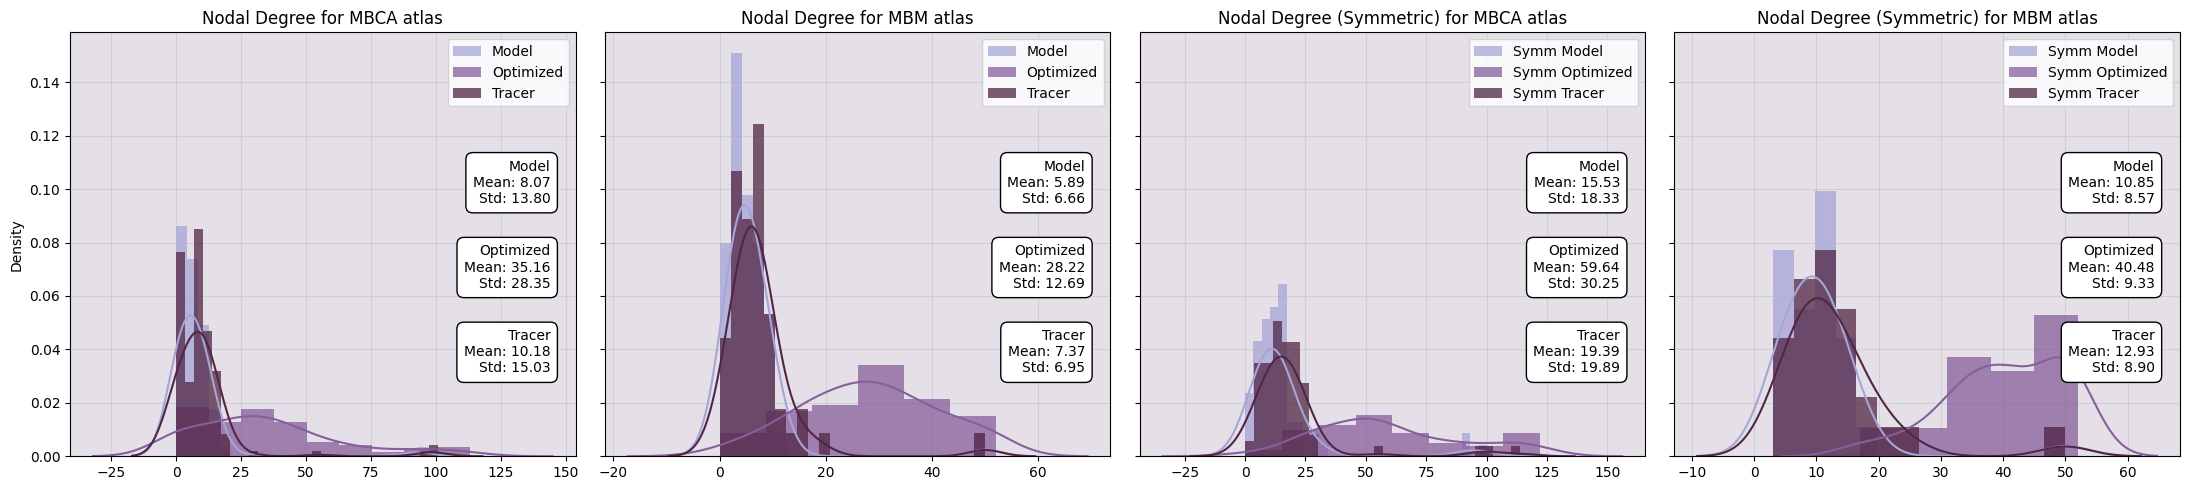

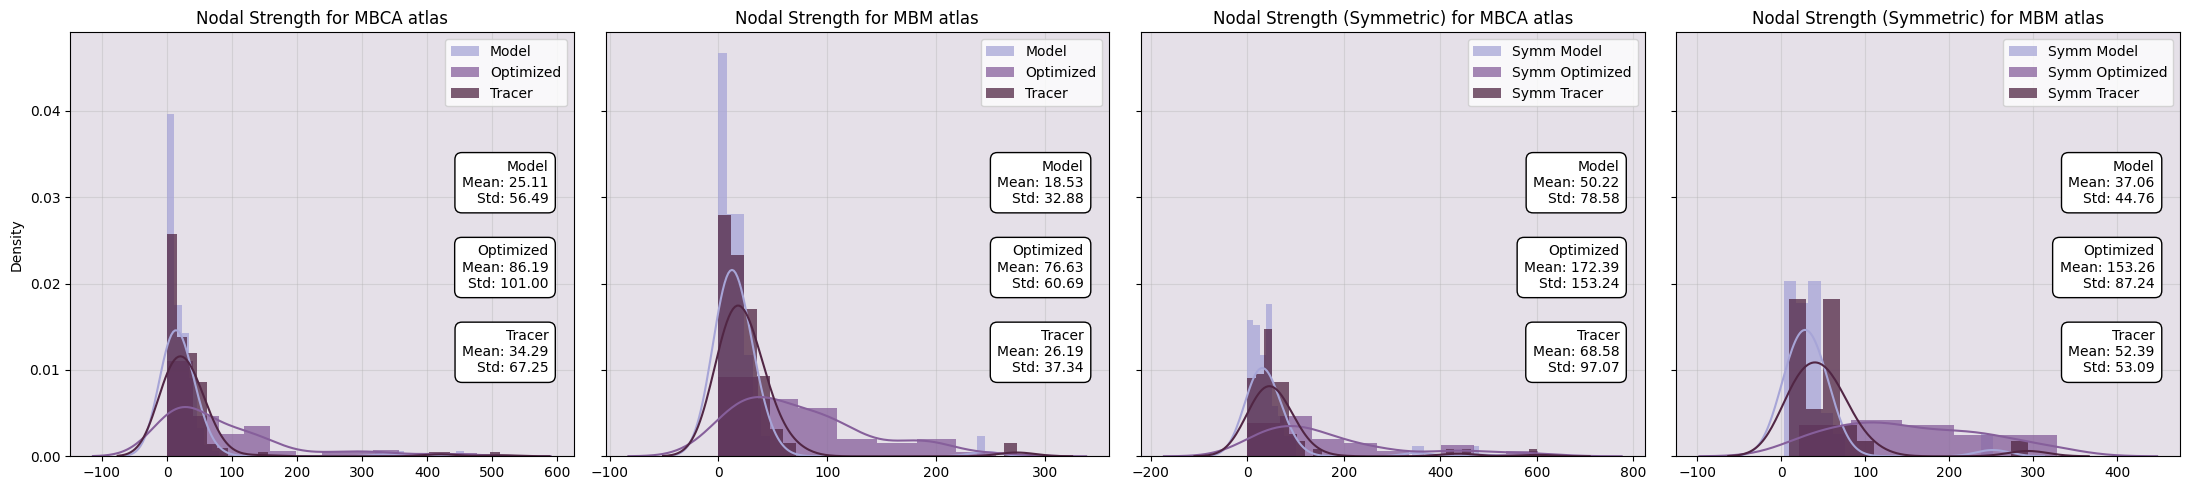

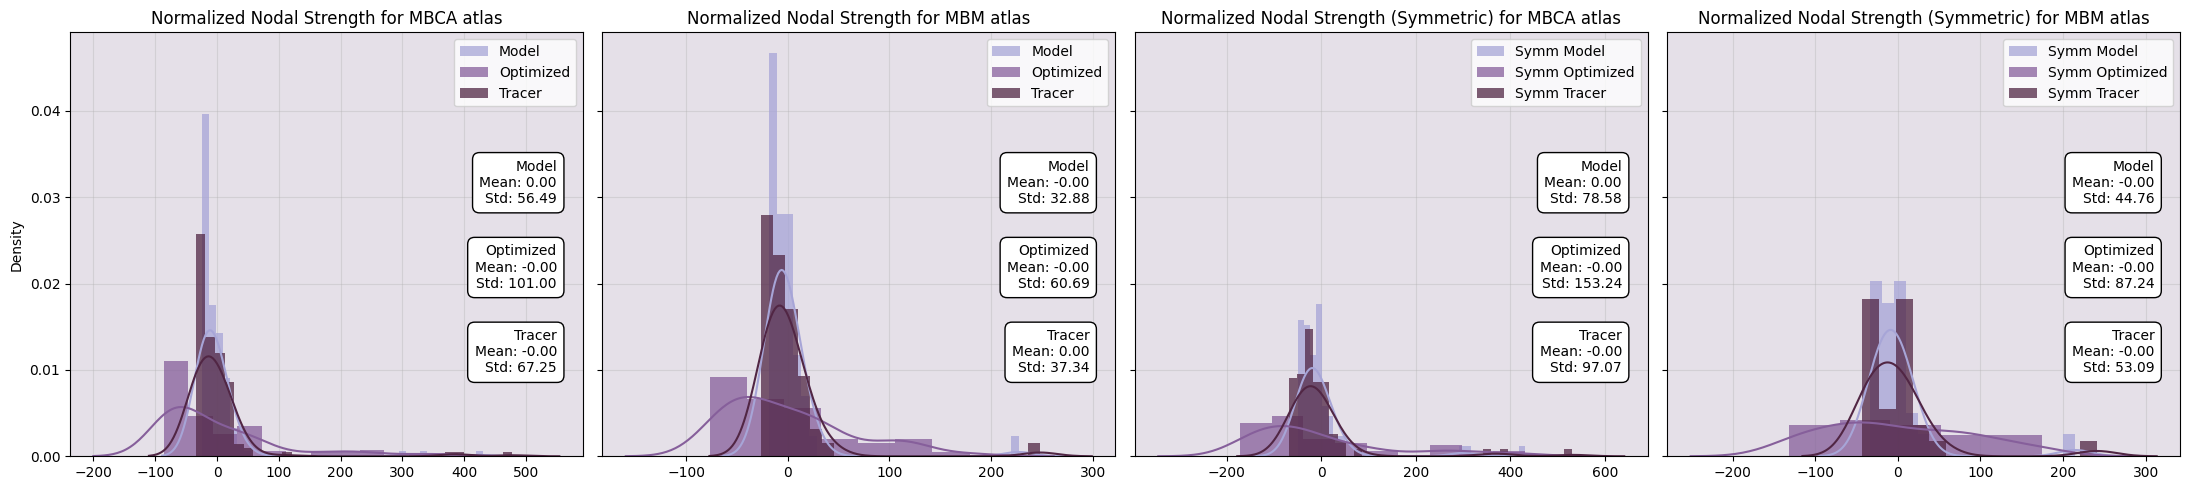

In [111]:
# Histograms for each atlas type
data_sets = {
    "Nodal Degree": {"Model": model_nodal_degree, "Optimized": optimized_nodal_degree, "Tracer": tracer_nodal_degree, "Symm Model": model_symm_nodal_degree, "Symm Optimized": optimized_symm_nodal_degree, "Symm Tracer": tracer_symm_nodal_degree},
    "Nodal Strength": {"Model": model_nodal_strength, "Optimized": optimized_nodal_strength, "Tracer": tracer_nodal_strength, "Symm Model": model_symm_nodal_strength, "Symm Optimized": optimized_symm_nodal_strength, "Symm Tracer": tracer_symm_nodal_strength},
    "Normalized Nodal Strength": {"Model": model_nodal_normalized_strength, "Optimized": optimized_nodal_normalized_strength, "Tracer": tracer_nodal_normalized_strength, "Symm Model": model_symm_nodal_normalized_strength, "Symm Optimized": optimized_symm_nodal_normalized_strength, "Symm Tracer": tracer_symm_nodal_normalized_strength}
}

for title, data in data_sets.items():
    make_subplots(data, title)

In [112]:
mean_data_sets = {
    "Mean Degree": {
        "Model": {
            "MBCA": model_mean_degrees["MBCA"],
            "MBM": model_mean_degrees["MBM"]
        },
        "Optimized": {
            "MBCA": optimized_mean_degrees["MBCA"],
            "MBM": optimized_mean_degrees["MBM"]
        },
        "Tracer": {
            "MBCA": tracer_mean_degrees["MBCA"],
            "MBM": tracer_mean_degrees["MBM"]
        },
    },
    "Mean Symm Degree": {
        "Model": {
            "MBCA": model_symm_mean_degrees["MBCA"],
            "MBM": model_symm_mean_degrees["MBM"]
        },
        "Optimized": {
            "MBCA": optimized_symm_mean_degrees["MBCA"],
            "MBM": optimized_symm_mean_degrees["MBM"]
        },
        "Tracer": {
            "MBCA": tracer_symm_mean_degrees["MBCA"],
            "MBM": tracer_symm_mean_degrees["MBM"]
        }
    },
    "Mean Strength": {
        "Model": {
            "MBCA": model_mean_strengths["MBCA"],
            "MBM": model_mean_strengths["MBM"]
        },
        "Optimized": {
            "MBCA": optimized_mean_strengths["MBCA"],
            "MBM": optimized_mean_strengths["MBM"]
        },
        "Tracer": {
            "MBCA": tracer_mean_strengths["MBCA"],
            "MBM": tracer_mean_strengths["MBM"]
        },
    },
    "Mean Symm Strength": {
        "Model": {
            "MBCA": model_symm_mean_strengths["MBCA"],
            "MBM": model_symm_mean_strengths["MBM"]
        },
        "Optimized": {
            "MBCA": optimized_symm_mean_strengths["MBCA"],
            "MBM": optimized_symm_mean_strengths["MBM"]
        },
        "Tracer": {
            "MBCA": tracer_symm_mean_strengths["MBCA"],
            "MBM": tracer_symm_mean_strengths["MBM"]
        }
    }
}

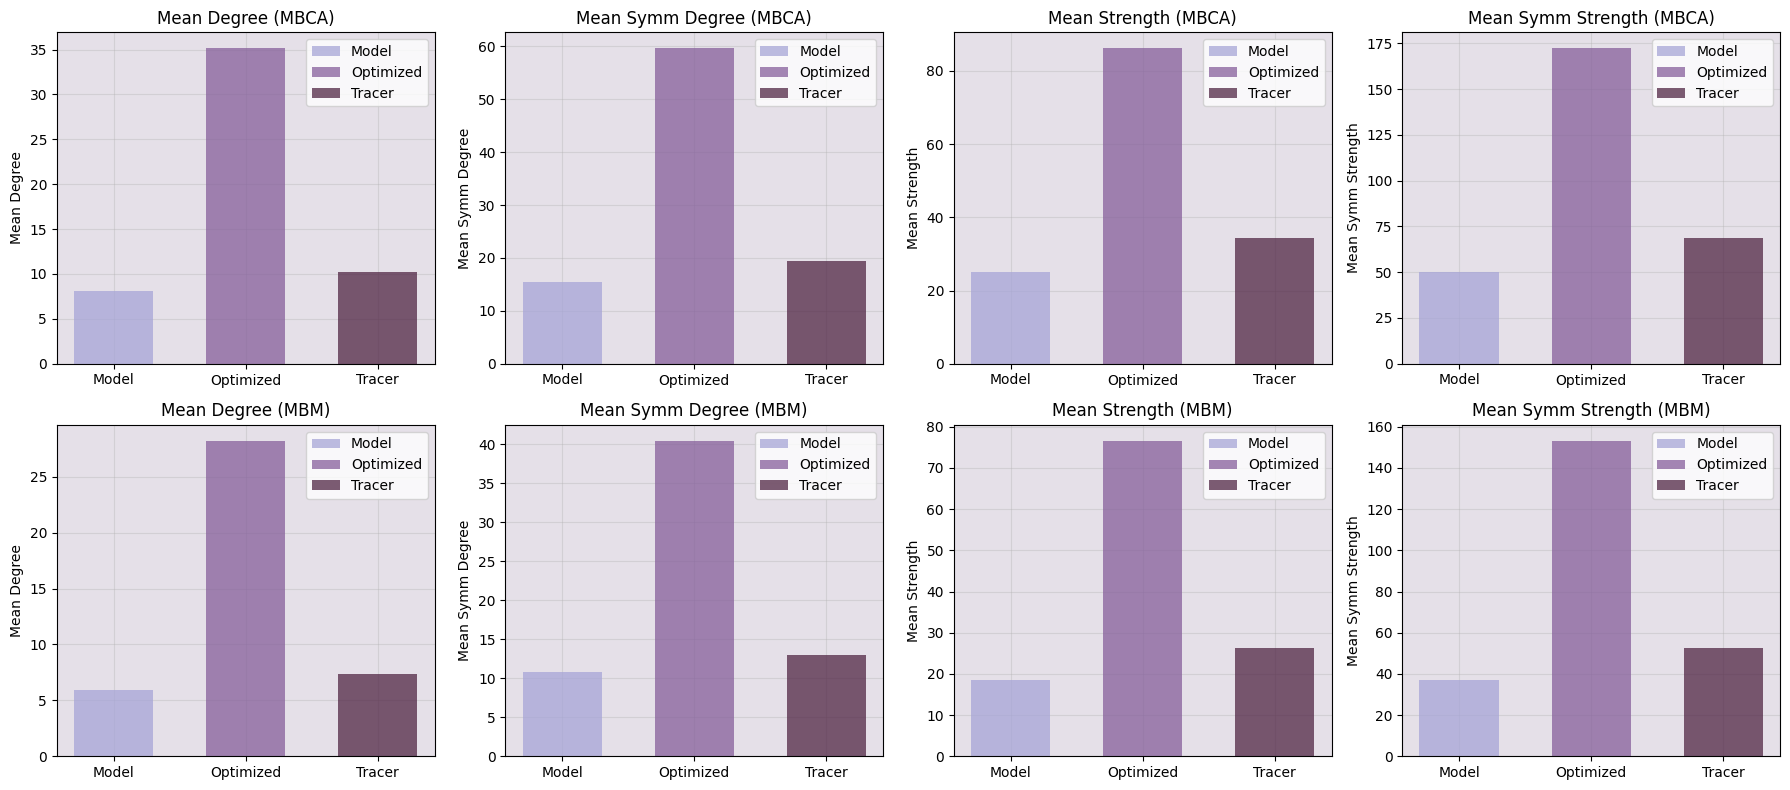

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Keep your style_plot function as-is:
def style_plot(ax, title, beige_color):
    ax.patch.set_facecolor(beige_color)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=alpha_grid)
    ax.set_axisbelow(True)

# Adjust the plot_mean_bar function:
def plot_mean_bar(ax, data, title, atlas):
    labels = ["Model", "Optimized", "Tracer"]
    
    model_value = data["Model"][atlas]
    optimized_value = data["Optimized"][atlas]
    tracer_value = data["Tracer"][atlas]
    
    values = [model_value, optimized_value, tracer_value]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    color_list = [pinkish, inbetween, purpleish]
    for k, (value, label, color) in enumerate(zip(values, labels, color_list)):
        ax.bar(x[k], value, width, color=color, alpha=alpha, label=label)

    ax.set_ylabel(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    style_plot(ax, "{} ({})".format(title, atlas), beige_color)

# Create the main figure and subplots:
fig, axs = plt.subplots(2, 4, figsize=(18, 8))

titles = ["Mean Degree", "Mean Symm Degree", "Mean Strength", "Mean Symm Strength"]
atlases = ["MBCA", "MBM"]

for i, atlas in enumerate(atlases):
    for j, title in enumerate(titles):
        plot_mean_bar(axs[i, j], mean_data_sets[title], title, atlas)

fig.tight_layout()
plt.show()


## **Centrality**

In [114]:
# Compute closeness, betweenness and eigenvector centrality
def compute_centrality(graphs):

    # Create a dictionary
    graph_distance = {}
    closeness_centrality = {}
    betweenness_centrality = {}
    eigenvector_centrality = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():

        # Compute a distance dictionary
        graph_distance[atlas_name] = {(e1, e2): 1 / abs(weight) for e1, e2, weight in graph.edges(data='weight')}

        # Add the distance dictionary to the graph
        nx.set_edge_attributes(graph, graph_distance[atlas_name], "distance")

        # Compute the closeness centrality
        closeness_centrality[atlas_name] = nx.closeness_centrality(graph, distance="distance")

        # Compute the betweenness centrality
        betweenness_centrality[atlas_name] = nx.betweenness_centrality(graph)

        # Compute the eigenvector centrality
        eigenvector_centrality[atlas_name] = nx.eigenvector_centrality(graph)

        # Add as attributes to the graph with atlas-specific names
        nx.set_node_attributes(graph, closeness_centrality[atlas_name], "{}_closeness".format(atlas_name))
        nx.set_node_attributes(graph, betweenness_centrality[atlas_name], "{}_betweenness".format(atlas_name))
        nx.set_node_attributes(graph, eigenvector_centrality[atlas_name], "{}_eigenvector".format(atlas_name))

    # Return the dictionary
    return closeness_centrality, betweenness_centrality, eigenvector_centrality

# Compute the stuff from the function above
(model_closeness_centrality, model_betweenness_centrality, 
 model_eigenvector_centrality) = compute_centrality(model_graphs)
(optimized_closeness_centrality, optimized_betweenness_centrality, 
 optimized_eigenvector_centrality) = compute_centrality(optimized_graphs)
(tracer_closeness_centrality, tracer_betweenness_centrality, 
 tracer_eigenvector_centrality) = compute_centrality(tracer_graphs)

# Compute the stuff from the function above - symmetrized
(model_symm_closeness_centrality, model_symm_betweenness_centrality, 
 model_symm_eigenvector_centrality) = compute_centrality(model_symm_graphs)
(optimized_symm_closeness_centrality, optimized_symm_betweenness_centrality,
    optimized_symm_eigenvector_centrality) = compute_centrality(optimized_symm_graphs)
(tracer_symm_closeness_centrality, tracer_symm_betweenness_centrality,
    tracer_symm_eigenvector_centrality) = compute_centrality(tracer_symm_graphs)

In [115]:
# Compute the page rank
def compute_page_rank(graphs):

    # Create a dictionary
    page_rank = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the page rank
        page_rank[atlas_name] = nx.pagerank(graph)

        # Add as attributes to the graph
        nx.set_node_attributes(graph, page_rank[atlas_name], "{}_page_rank".format(atlas_name))

    # Return the dictionary
    return page_rank

# Compute the stuff from the function above
model_page_rank = compute_page_rank(model_graphs)
optimized_page_rank = compute_page_rank(optimized_graphs)
tracer_page_rank = compute_page_rank(tracer_graphs)

# Compute the stuff from the function above - symmetrized
model_symm_page_rank = compute_page_rank(model_symm_graphs)
optimized_symm_page_rank = compute_page_rank(optimized_symm_graphs)
tracer_symm_page_rank = compute_page_rank(tracer_symm_graphs)

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

atlases = ["MBCA", "MBM"]

alpha = 0.75  # Transparency of the histograms
alpha_grid = 0.35  # Transparency of the grid

# Generate a cubehelix color palette with more contrast
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)  # Adjust dark and light parameters
pinkish = color_palette[2]  # Adjusted index for higher contrast pink
purpleish = color_palette[6]  # Adjusted index for higher contrast purple
inbetween = color_palette[4]  # Keeping the intermediate color

beige_palette = sns.light_palette(color_palette[4], n_colors=10)
beige_color = beige_palette[1]  # Picking a lighter shade from the generated beige palette

def make_subplots(data, title_prefix):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(22, 5))

    for idx, atlas in enumerate(atlases):
        
        # Get the data
        model_data = data["Model"][atlas]
        optimized_data = data["Optimized"][atlas]
        tracer_data = data["Tracer"][atlas]
        symm_model_data = data["Model Symm"][atlas]
        symm_optimized_data = data["Optimized Symm"][atlas]
        symm_tracer_data = data["Tracer Symm"][atlas]
        
        # Get the values depending on the type
        if hasattr(model_data, 'values'):
            model_data = model_data.values()
        if hasattr(optimized_data, 'values'):
            optimized_data = optimized_data.values()
        if hasattr(tracer_data, 'values'):
            tracer_data = tracer_data.values()

        if hasattr(symm_model_data, 'values'):
            symm_model_data = symm_model_data.values()
        if hasattr(symm_optimized_data, 'values'):
            symm_optimized_data = symm_optimized_data.values()
        if hasattr(symm_tracer_data, 'values'):
            symm_tracer_data = symm_tracer_data.values()

        # Get the mean and std
        model_mean, model_std = np.mean(np.array(list(model_data))), np.std(np.array(list(model_data)))
        optimized_mean, optimized_std = np.mean(np.array(list(optimized_data))), np.std(np.array(list(optimized_data)))
        tracer_mean, tracer_std = np.mean(np.array(list(tracer_data))), np.std(np.array(list(tracer_data)))
        symm_model_mean, symm_model_std = np.mean(np.array(list(symm_model_data))), np.std(np.array(list(symm_model_data)))
        symm_optimized_mean, symm_optimized_std = np.mean(np.array(list(symm_optimized_data))), np.std(np.array(list(symm_optimized_data)))
        symm_tracer_mean, symm_tracer_std = np.mean(np.array(list(symm_tracer_data))), np.std(np.array(list(symm_tracer_data)))

        # Plot the data
        sns.distplot(list(model_data), color=pinkish, label="Model", ax=axes[idx], hist_kws={'alpha': alpha})
        sns.distplot(list(optimized_data), color=inbetween, label="Optimized", ax=axes[idx], hist_kws={'alpha': alpha})
        sns.distplot(list(tracer_data), color=purpleish, label="Tracer", ax=axes[idx], hist_kws={'alpha': alpha})
        sns.distplot(list(symm_model_data), color=pinkish, label="Symm Model", ax=axes[idx + len(atlases)], hist_kws={'alpha': alpha})
        sns.distplot(list(symm_optimized_data), color=inbetween, label="Symm Optimized", ax=axes[idx + len(atlases)], hist_kws={'alpha': alpha})
        sns.distplot(list(symm_tracer_data), color=purpleish, label="Symm Tracer", ax=axes[idx + len(atlases)], hist_kws={'alpha': alpha})
        
        axes[idx].patch.set_facecolor(beige_color)
        axes[idx].legend()
        axes[idx].set_title("{} for {} atlas".format(title_prefix, atlas))
        axes[idx].grid(True, alpha=alpha_grid)
        axes[idx].set_axisbelow(True)

        # Formatting for the text box
        box_format = {'facecolor': 'white', 'edgecolor': 'black', 'boxstyle': 'round,pad=0.5'}

        # Draw the mean and std as text on the plot (Model, Optimized, Tracer)
        axes[idx].text(0.95, 0.70, "Model\nMean: {:.2f}\nStd: {:.2f}".format(model_mean, model_std),
                       transform=axes[idx].transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        axes[idx].text(0.95, 0.50, "Optimized\nMean: {:.2f}\nStd: {:.2f}".format(optimized_mean, optimized_std),
                       transform=axes[idx].transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        axes[idx].text(0.95, 0.30, "Tracer\nMean: {:.2f}\nStd: {:.2f}".format(tracer_mean, tracer_std),
                       transform=axes[idx].transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)


        # Plot the data for the symmetric version
        ax_symm = axes[idx + len(atlases)]

        # Apply the formatting
        ax_symm.patch.set_facecolor(beige_color)
        ax_symm.legend()
        ax_symm.set_title("{} (Symmetric) for {} atlas".format(title_prefix, atlas))
        ax_symm.grid(True, alpha=alpha_grid)
        ax_symm.set_axisbelow(True)

        # Draw the mean and std as text on the symmetric plot (Symm Model, Symm Optimized, Symm Tracer)
        ax_symm.text(0.95, 0.70, "Model\nMean: {:.2f}\nStd: {:.2f}".format(symm_model_mean, symm_model_std),
                     transform=ax_symm.transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        ax_symm.text(0.95, 0.50, "Optimized\nMean: {:.2f}\nStd: {:.2f}".format(symm_optimized_mean, symm_optimized_std),
                     transform=ax_symm.transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
        ax_symm.text(0.95, 0.30, "Tracer\nMean: {:.2f}\nStd: {:.2f}".format(symm_tracer_mean, symm_tracer_std),
                     transform=ax_symm.transAxes, verticalalignment='top', horizontalalignment='right', bbox=box_format)
    
    plt.tight_layout()
    plt.show()

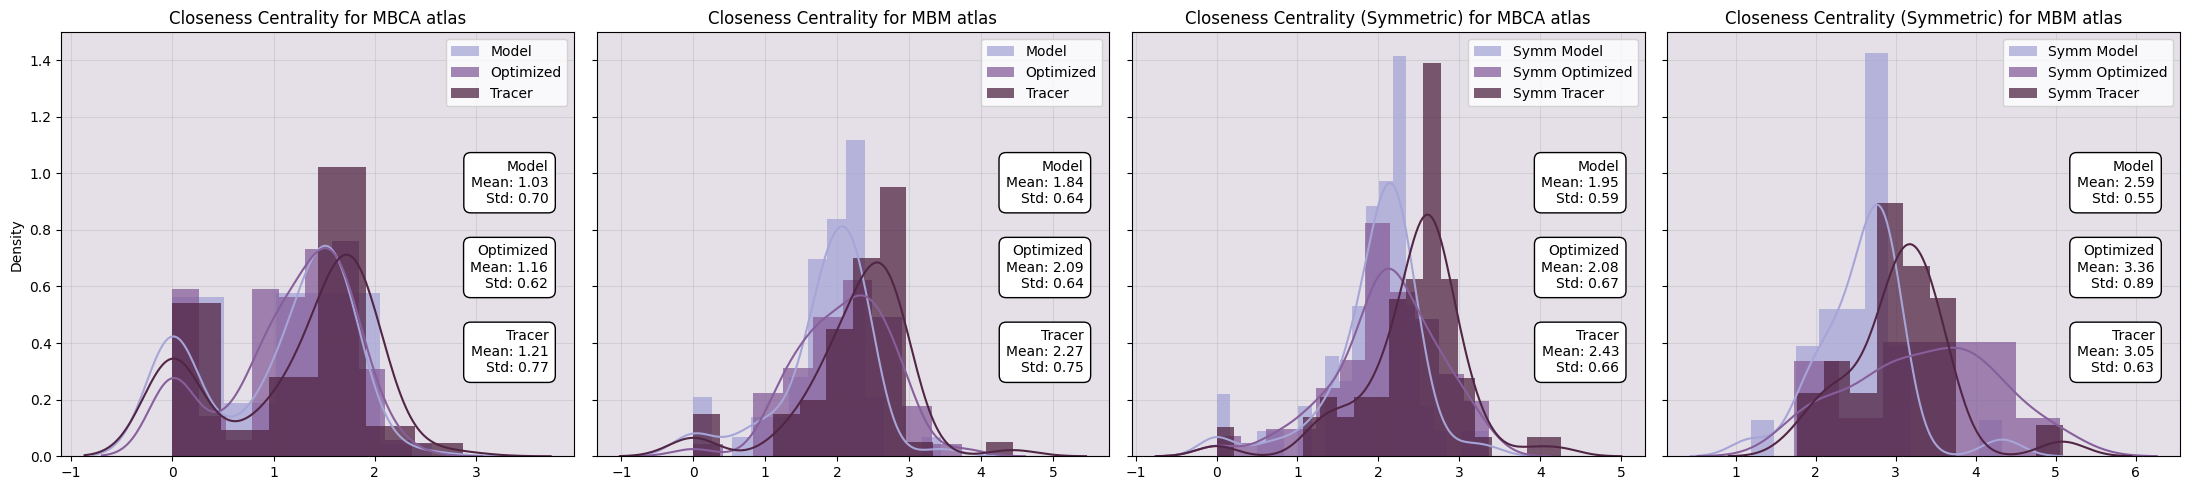

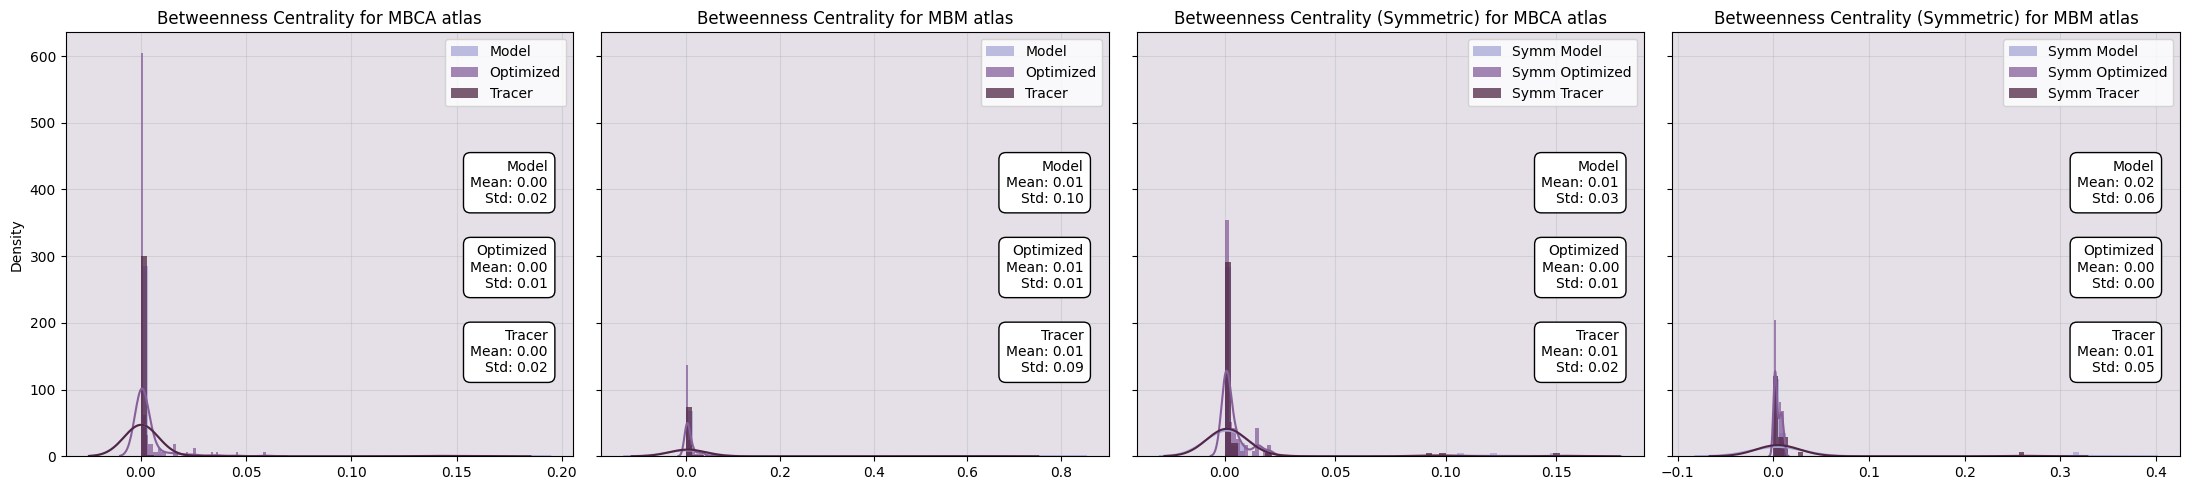

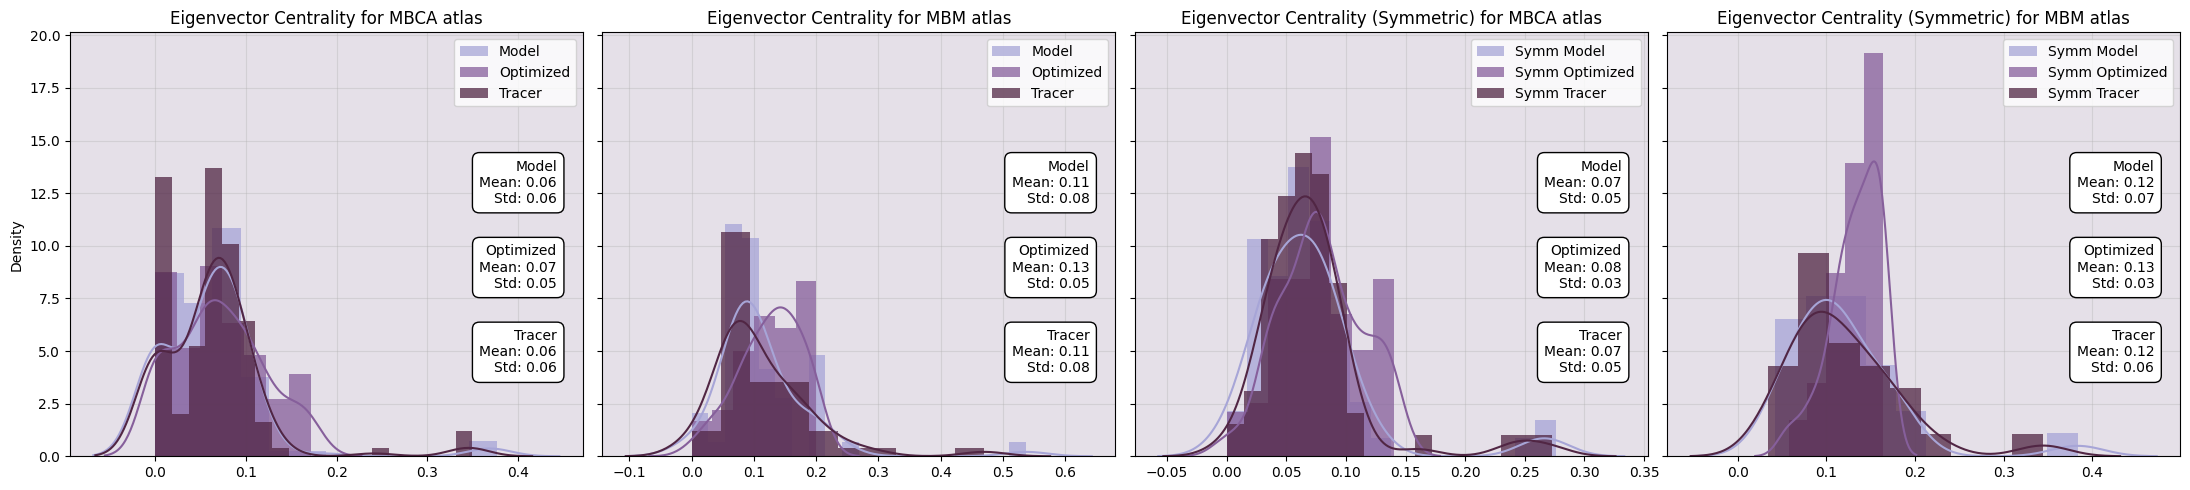

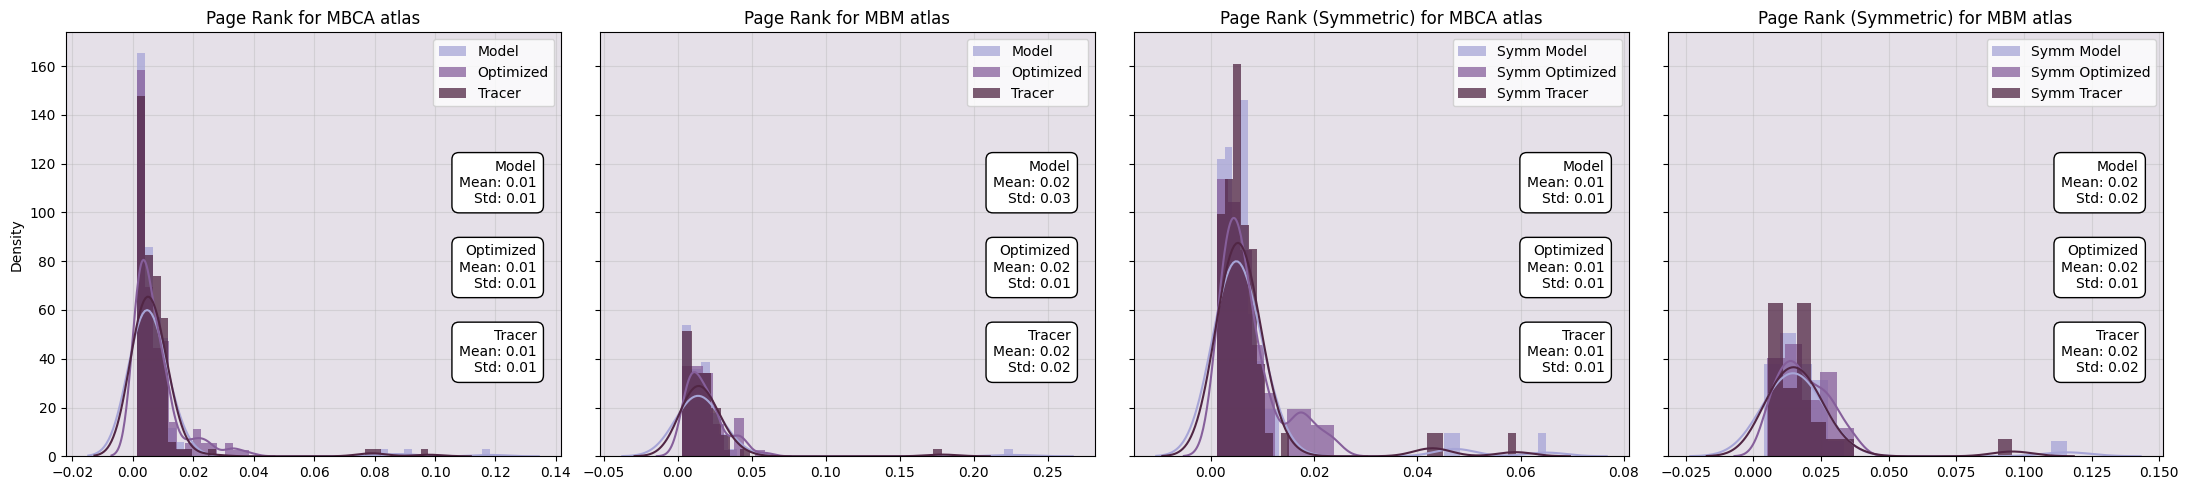

In [117]:
# Histograms for each atlas type
data_sets = {
    "Closeness Centrality": {"Model": model_closeness_centrality, "Optimized": optimized_closeness_centrality, "Tracer": tracer_closeness_centrality, "Model Symm": model_symm_closeness_centrality, "Optimized Symm": optimized_symm_closeness_centrality, "Tracer Symm": tracer_symm_closeness_centrality},
    "Betweenness Centrality": {"Model": model_betweenness_centrality, "Optimized": optimized_betweenness_centrality, "Tracer": tracer_betweenness_centrality, "Model Symm": model_symm_betweenness_centrality, "Optimized Symm": optimized_symm_betweenness_centrality, "Tracer Symm": tracer_symm_betweenness_centrality},
    "Eigenvector Centrality": {"Model": model_eigenvector_centrality, "Optimized": optimized_eigenvector_centrality, "Tracer": tracer_eigenvector_centrality, "Model Symm": model_symm_eigenvector_centrality, "Optimized Symm": optimized_symm_eigenvector_centrality, "Tracer Symm": tracer_symm_eigenvector_centrality},
    "Page Rank": {"Model": model_page_rank, "Optimized": optimized_page_rank, "Tracer": tracer_page_rank, "Model Symm": model_symm_page_rank, "Optimized Symm": optimized_symm_page_rank, "Tracer Symm": tracer_symm_page_rank}
}

for title, data in data_sets.items():
    make_subplots(data, title)

#### **Path Length**
**Defintion**: A graph's density is the ratio between the number of edges and the total number of possible edges.

In [118]:
# Define the dijkstra function
def dijkstra(graph, source, target):
    # Compute the shortest path
    shortest_path = nx.dijkstra_path(graph, source, target, weight="distance")
    # Compute the shortest path length
    shortest_path_length = nx.dijkstra_path_length(graph, source, target, weight="distance")
    # Compute the shortest path length without the source
    shortest_path_no_source = nx.shortest_path_length(graph, weight="distance")
    # Compute the shortest path for all pairs
    shortest_path_all_pairs = dict(nx.all_pairs_dijkstra_path(graph, weight="distance"))
    # Return the shortest path and shortest path length
    return shortest_path, shortest_path_length, shortest_path_no_source, shortest_path_all_pairs

# Define the function to compute the shortest path and shortest path length
def compute_shortest_path_and_length(graphs):

    # Create a dictionary
    shortest_path = {}
    shortest_path_length = {}
    shortest_path_no_source = {}
    shortest_path_all_pairs = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the shortest path and shortest path length
        (shortest_path[atlas_name], 
         shortest_path_length[atlas_name],
        shortest_path_no_source[atlas_name], 
        shortest_path_all_pairs[atlas_name]) = dijkstra(graph, 0, 1)

    # Return the dictionary
    return shortest_path, shortest_path_length, shortest_path_no_source, shortest_path_all_pairs

# Compute the stuff from the function above
(model_shortest_path, model_shortest_path_length,
 model_shortest_path_no_source, model_shortest_path_all_pairs) = compute_shortest_path_and_length(model_graphs)
(optimized_shortest_path, optimized_shortest_path_length,
  optimized_shortest_path_no_source, optimized_shortest_path_all_pairs) = compute_shortest_path_and_length(optimized_graphs)
(tracer_shortest_path, tracer_shortest_path_length,
  tracer_shortest_path_no_source, tracer_shortest_path_all_pairs) = compute_shortest_path_and_length(tracer_graphs)

# Compute the stuff from the function above - symmetrized
(model_symm_shortest_path, model_symm_shortest_path_length,
  model_symm_shortest_path_no_source, model_symm_hortest_path_all_pairs) = compute_shortest_path_and_length(model_symm_graphs)
(optimized_symm_shortest_path, optimized_symm_shortest_path_length,
   optimized_symm_shortest_path_no_source, optimized_symm_hortest_path_all_pairs)  = compute_shortest_path_and_length(optimized_symm_graphs)
(tracer_symm_shortest_path, tracer_symm_shortest_path_length,
   tracer_symm_shortest_path_no_source, tracer_symm_hortest_path_all_pairs)  = compute_shortest_path_and_length(tracer_symm_graphs)

# Print the shortest path and shortest path length
print("Model shortest path: {}".format(model_shortest_path))
print("Optimized shortest path: {}".format(optimized_shortest_path))
print("Tracer shortest path: {}".format(tracer_shortest_path))

print("----------------------------------------")

print("Model shortest path length: {}".format(model_shortest_path_length))
print("Optimized shortest path length: {}".format(optimized_shortest_path_length))
print("Tracer shortest path length: {}".format(tracer_shortest_path_length))

Model shortest path: {'MBCA': [0, 30, 1], 'MBM': [0, 15, 1]}
Optimized shortest path: {'MBCA': [0, 1], 'MBM': [0, 1]}
Tracer shortest path: {'MBCA': [0, 30, 1], 'MBM': [0, 15, 1]}
----------------------------------------
Model shortest path length: {'MBCA': 0.32541895671558835, 'MBM': 0.5196305627300326}
Optimized shortest path length: {'MBCA': 0.12294254289874777, 'MBM': 0.2710850306818168}
Tracer shortest path length: {'MBCA': 0.30497240873360065, 'MBM': 0.46293544640070183}


In [119]:
mean_data_sets = {
    "Shortest Path Length": {
        "Model": {
            "MBCA": model_shortest_path_length["MBCA"],
            "MBM": model_shortest_path_length["MBM"]
        },
        "Optimized": {
            "MBCA": optimized_shortest_path_length["MBCA"],
            "MBM": optimized_shortest_path_length["MBM"]
        },
        "Tracer": {
            "MBCA": tracer_shortest_path_length["MBCA"],
            "MBM": tracer_shortest_path_length["MBM"]
        },
    },
    "Shortest Path Length Symm": {
        "Model": {
            "MBCA": model_symm_shortest_path_length["MBCA"],
            "MBM": model_symm_shortest_path_length["MBM"]
        },
        "Optimized": {
            "MBCA": optimized_symm_shortest_path_length["MBCA"],
            "MBM": optimized_symm_shortest_path_length["MBM"]
        },
        "Tracer": {
            "MBCA": tracer_symm_shortest_path_length["MBCA"],
            "MBM": tracer_symm_shortest_path_length["MBM"]
        }
    }
}

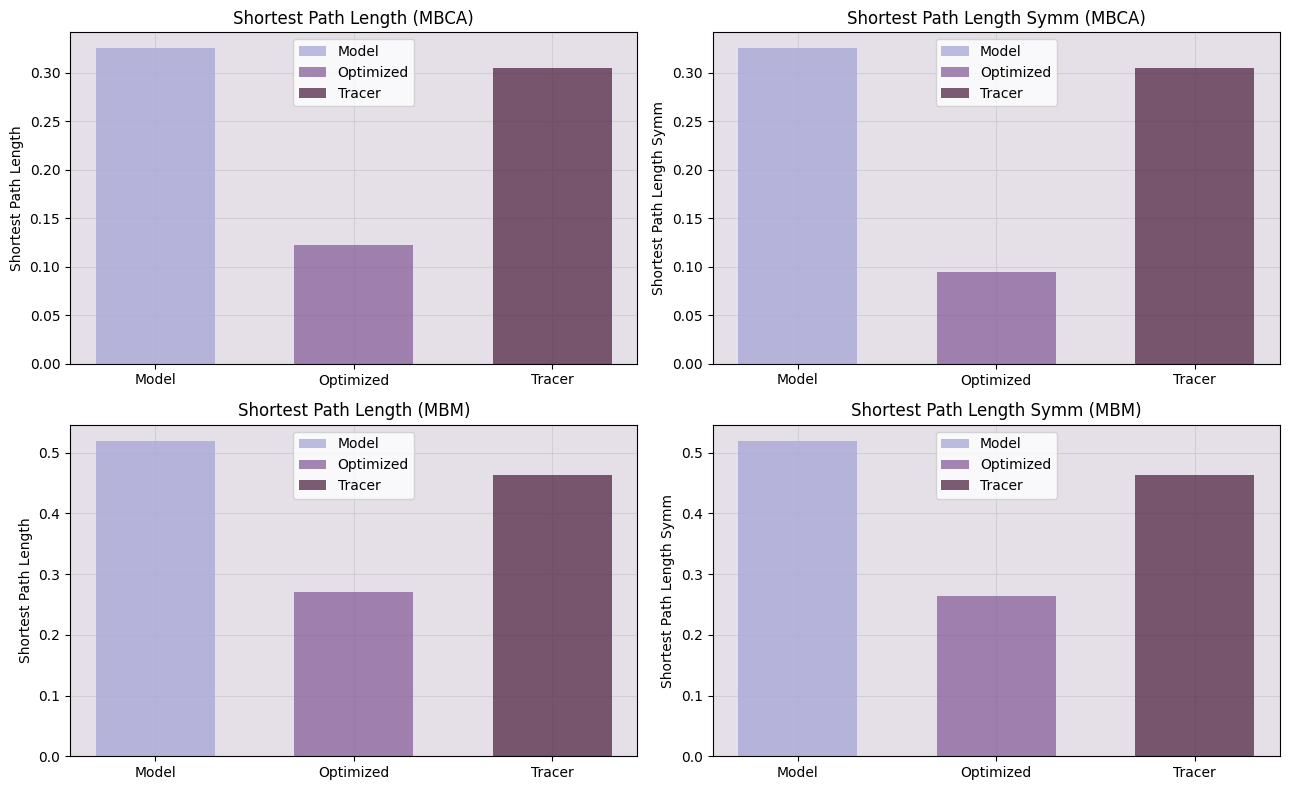

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Keep your style_plot function as-is:
def style_plot(ax, title, beige_color):
    ax.patch.set_facecolor(beige_color)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=alpha_grid)
    ax.set_axisbelow(True)

# Adjust the plot_mean_bar function:
def plot_mean_bar(ax, data, title, atlas):
    labels = ["Model", "Optimized", "Tracer"]
    
    model_value = data["Model"][atlas]
    optimized_value = data["Optimized"][atlas]
    tracer_value = data["Tracer"][atlas]
    
    values = [model_value, optimized_value, tracer_value]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    color_list = [pinkish, inbetween, purpleish]
    for k, (value, label, color) in enumerate(zip(values, labels, color_list)):
        ax.bar(x[k], value, width, color=color, alpha=alpha, label=label)

    ax.set_ylabel(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    style_plot(ax, "{} ({})".format(title, atlas), beige_color)

# Create the main figure and subplots:
fig, axs = plt.subplots(2, 2, figsize=(13, 8))

titles = ["Shortest Path Length", "Shortest Path Length Symm"]
atlases = ["MBCA", "MBM"]

for i, atlas in enumerate(atlases):
    for j, title in enumerate(titles):
        plot_mean_bar(axs[i, j], mean_data_sets[title], title, atlas)

fig.tight_layout()
plt.show()


#### **Modularity, Assortativity, Clustering Coeff, Minimum Spanning Tree**
**Defintion**: A graph's density is the ratio between the number of edges and the total number of possible edges.

In [121]:
# Modularity
def compute_modularity(graphs):

    # Create a dictionary
    modularity = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the modularity
        modularity[atlas_name] = nx.algorithms.community.modularity_max.greedy_modularity_communities(graph)

        # Add as attributes to the graph
        nx.set_node_attributes(graph, modularity[atlas_name], "{}_modularity".format(atlas_name))

    # Return the dictionary
    return modularity

# Compute the stuff from the function above
model_modularity = compute_modularity(model_graphs)
optimized_modularity = compute_modularity(optimized_graphs)
tracer_modularity = compute_modularity(tracer_graphs)

# Compute the stuff from the function above - symmetrized
model_symm_modularity = compute_modularity(model_symm_graphs)
optimized_symm_modularity = compute_modularity(optimized_symm_graphs)
tracer_symm_modularity = compute_modularity(tracer_symm_graphs)

# Print the modularity
print("Model modularity: {}".format(model_modularity))
print("Optimized modularity: {}".format(optimized_modularity))
print("Tracer modularity: {}".format(tracer_modularity))

print("----------------------------------------")

print("Model symmetrized modularity: {}".format(model_symm_modularity))
print("Optimized symmetrized modularity: {}".format(optimized_symm_modularity))
print("Tracer symmetrized modularity: {}".format(tracer_symm_modularity))

Model modularity: {'MBCA': [frozenset({1, 66, 2, 3, 4, 6, 71, 72, 8, 74, 82, 83, 24, 25, 26, 27, 96, 32, 33, 99, 34, 35, 102, 45, 111, 49, 121}), frozenset({129, 130, 131, 70, 9, 80, 84, 92, 120, 104, 106, 42, 112, 113, 114, 115, 116, 53, 118, 119, 56, 123, 127}), frozenset({0, 128, 132, 133, 134, 75, 14, 78, 17, 18, 86, 23, 88, 87, 89, 90, 29, 105, 41, 107, 108, 50}), frozenset({69, 10, 12, 13, 15, 16, 19, 20, 21, 22, 55, 117, 57, 91, 30}), frozenset({36, 37, 38, 39, 40, 43, 44, 46, 47, 28, 31}), frozenset({5}), frozenset({7}), frozenset({11}), frozenset({48}), frozenset({51}), frozenset({52}), frozenset({54}), frozenset({58}), frozenset({59}), frozenset({60}), frozenset({61}), frozenset({62}), frozenset({63}), frozenset({64}), frozenset({65}), frozenset({67}), frozenset({68}), frozenset({73}), frozenset({76}), frozenset({77}), frozenset({79}), frozenset({81}), frozenset({85}), frozenset({93}), frozenset({94}), frozenset({95}), frozenset({97}), frozenset({98}), frozenset({100}), froze

In [122]:
import community

# Find modularity using community
def find_modularity(graphs):

    # Create a dictionary
    modularity = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the modularity
        modularity[atlas_name] = community.best_partition(graph, weight="weight")

    # Return the dictionary
    return modularity

# Compute the stuff from the function above
model_modularity = find_modularity(model_graphs)
optimized_modularity = find_modularity(optimized_graphs)
tracer_modularity = find_modularity(tracer_graphs)

# Compute the stuff from the function above - symmetrized
model_symm_modularity = find_modularity(model_symm_graphs)
optimized_symm_modularity = find_modularity(optimized_symm_graphs)
tracer_symm_modularity = find_modularity(tracer_symm_graphs)

# Print the number of communities for each atlas
print("Model number of communities: {}".format(len(set(model_modularity["MBCA"].values()).union())))
print("Optimized number of communities: {}".format(len(set(optimized_modularity["MBCA"].values()).union())))
print("Tracer number of communities: {}".format(len(set(tracer_modularity["MBCA"].values()).union())))

print("----------------------------------------")

print("Model symmetrized number of communities: {}".format(len(set(model_symm_modularity["MBCA"].values()).union())))
print("Optimized symmetrized number of communities: {}".format(len(set(optimized_symm_modularity["MBCA"].values()).union())))
print("Tracer symmetrized number of communities: {}".format(len(set(tracer_symm_modularity["MBCA"].values()).union())))

Model number of communities: 42
Optimized number of communities: 25
Tracer number of communities: 38
----------------------------------------
Model symmetrized number of communities: 9
Optimized symmetrized number of communities: 7
Tracer symmetrized number of communities: 8


In [123]:
# Function to compute the assortativity
def find_assortativity(graphs):

    # Create a dictionary
    assortativity = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the assortativity
        assortativity[atlas_name] = nx.degree_assortativity_coefficient(graph)

    # Return the dictionary
    return assortativity

# Compute the stuff from the function above
model_assortativity = find_assortativity(model_graphs)
optimized_assortativity = find_assortativity(optimized_graphs)
tracer_assortativity = find_assortativity(tracer_graphs)

# Compute the stuff from the function above - symmetrized
model_symm_assortativity = find_assortativity(model_symm_graphs)
optimized_symm_assortativity = find_assortativity(optimized_symm_graphs)
tracer_symm_assortativity = find_assortativity(tracer_symm_graphs)

# Print the assortativity
print("Model assortativity: {}".format(model_assortativity))
print("Optimized assortativity: {}".format(optimized_assortativity))
print("Tracer assortativity: {}".format(tracer_assortativity))

print("----------------------------------------")

print("Model symmetrized assortativity: {}".format(model_symm_assortativity))
print("Optimized symmetrized assortativity: {}".format(optimized_symm_assortativity))
print("Tracer symmetrized assortativity: {}".format(tracer_symm_assortativity))

Model assortativity: {'MBCA': -0.3669488533569012, 'MBM': -0.24339915934169348}
Optimized assortativity: {'MBCA': -0.3214269129173865, 'MBM': -0.26897516444391445}
Tracer assortativity: {'MBCA': -0.3215354198685327, 'MBM': -0.2151912641525421}
----------------------------------------
Model symmetrized assortativity: {'MBCA': -0.3530041798041252, 'MBM': -0.2407036123819905}
Optimized symmetrized assortativity: {'MBCA': -0.2622395477304517, 'MBM': -0.16406167338938427}
Tracer symmetrized assortativity: {'MBCA': -0.3075403315906919, 'MBM': -0.2254868680037688}


In [124]:
# Function to compute the clustering coefficient
def find_clustering_coefficient(graphs):

    # Create a dictionary
    clustering_coefficient = {}
    average_clustering_coefficient = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the average clustering coefficient
        clustering_coefficient[atlas_name] = nx.clustering(graph, weight="weight")
        # Compute the average clustering coefficient
        average_clustering_coefficient[atlas_name] = nx.average_clustering(graph, weight="weight")
        # Add as attributes to the graph
        nx.set_node_attributes(graph, clustering_coefficient[atlas_name], "{}_clustering_coefficient".format(atlas_name))

    # Return the dictionary
    return clustering_coefficient, average_clustering_coefficient

# Compute the stuff from the function above
(model_clustering_coefficient, 
 model_average_clustering_coefficient) = find_clustering_coefficient(model_graphs)
(optimized_clustering_coefficient,
 optimized_average_clustering_coefficient) = find_clustering_coefficient(optimized_graphs)
(tracer_clustering_coefficient,
 tracer_average_clustering_coefficient) = find_clustering_coefficient(tracer_graphs)

# Compute the stuff from the function above - symmetrized
(model_symm_clustering_coefficient,
 model_symm_average_clustering_coefficient) = find_clustering_coefficient(model_symm_graphs)
(optimized_symm_clustering_coefficient,
 optimized_symm_average_clustering_coefficient) = find_clustering_coefficient(optimized_symm_graphs)
(tracer_symm_clustering_coefficient,
 tracer_symm_average_clustering_coefficient) = find_clustering_coefficient(tracer_symm_graphs)

# Print the clustering coefficient
print("Model clustering coefficient: {}".format(model_clustering_coefficient))
print("Optimized clustering coefficient: {}".format(optimized_clustering_coefficient))
print("Tracer clustering coefficient: {}".format(tracer_clustering_coefficient))

print("----------------------------------------")

print("Model symmetrized clustering coefficient: {}".format(model_symm_clustering_coefficient))
print("Optimized symmetrized clustering coefficient: {}".format(optimized_symm_clustering_coefficient))
print("Tracer symmetrized clustering coefficient: {}".format(tracer_symm_clustering_coefficient))

Model clustering coefficient: {'MBCA': {0: 0.2716577241396516, 1: 0.20976873235849036, 2: 0.2434403990435949, 3: 0.34494725308399593, 4: 0.2408390650527861, 5: 0, 6: 0.22736464734251277, 7: 0, 8: 0.2192507289349853, 9: 0.3251138032806771, 10: 0.23314632720456502, 11: 0, 12: 0.2226431235327356, 13: 0.22722497172910983, 14: 0.20668294327171371, 15: 0.22902677450813894, 16: 0.20336425720057727, 17: 0.33806033054691875, 18: 0.14029954937666536, 19: 0.28013408453552135, 20: 0.16263141537064457, 21: 0.24512982276426573, 22: 0.26503636395045554, 23: 0.2505077723281641, 24: 0.1729195384092325, 25: 0.23517696666837326, 26: 0.2024101164392304, 27: 0.15194455061199322, 28: 0.2624849135497562, 29: 0.21555772424057926, 30: 0.04180521375332921, 31: 0.21206419390512726, 32: 0.2535466173450048, 33: 0.09711099968535689, 34: 0.302820353434832, 35: 0.4037251471868491, 36: 0.3270721359333427, 37: 0.32365590800441313, 38: 0.26904430941424146, 39: 0.3136772576695522, 40: 0.3719017351079461, 41: 0.0396804833

In [125]:
data_sets = {
    "Number of Communities" : {
        "Model" : {
            "MBCA" : len(set(model_symm_modularity["MBCA"].values()).union()),
            "MBM" : len(set(model_symm_modularity["MBM"].values()).union())
        },
        "Optimized" : {
            "MBCA" : len(set(optimized_symm_modularity["MBCA"].values()).union()),
            "MBM" : len(set(optimized_symm_modularity["MBM"].values()).union())
        },
        "Tracer" : {
            "MBCA" : len(set(tracer_symm_modularity["MBCA"].values()).union()),
            "MBM" : len(set(tracer_symm_modularity["MBM"].values()).union())
        }
    },
    "Number of Communities Symm" : {
        "Model" : {
            "MBCA" : len(set(model_symm_modularity["MBCA"].values()).union()),
            "MBM" : len(set(model_symm_modularity["MBM"].values()).union())
        },
        "Optimized" : {
            "MBCA" : len(set(optimized_symm_modularity["MBCA"].values()).union()),
            "MBM" : len(set(optimized_symm_modularity["MBM"].values()).union())
        },
        "Tracer" : {
            "MBCA" : len(set(tracer_symm_modularity["MBCA"].values()).union()),
            "MBM" : len(set(tracer_symm_modularity["MBM"].values()).union())
        }
    },

    "Assortativity" : {
        "Model" : {
            "MBCA" : model_assortativity["MBCA"],
            "MBM" : model_assortativity["MBM"]
        },
        "Optimized" : {
            "MBCA" : optimized_assortativity["MBCA"],
            "MBM" : optimized_assortativity["MBM"]
        },
        "Tracer" : {
            "MBCA" : tracer_assortativity["MBCA"],
            "MBM" : tracer_assortativity["MBM"]
        }
    },
    "Assortativity Symm" : {
        "Model" : {
            "MBCA" : model_symm_assortativity["MBCA"],
            "MBM" : model_symm_assortativity["MBM"]
        },
        "Optimized" : {
            "MBCA" : optimized_symm_assortativity["MBCA"],
            "MBM" : optimized_symm_assortativity["MBM"]
        },
        "Tracer" : {
            "MBCA" : tracer_symm_assortativity["MBCA"],
            "MBM" : tracer_symm_assortativity["MBM"]
        }
    },

    "Average Clustering Coefficient" : {
        "Model" : {
            "MBCA" : model_average_clustering_coefficient["MBCA"],
            "MBM" : model_average_clustering_coefficient["MBM"]
        },
        "Optimized" : {
            "MBCA" : optimized_average_clustering_coefficient["MBCA"],
            "MBM" : optimized_average_clustering_coefficient["MBM"]
        },
        "Tracer" : {
            "MBCA" : tracer_average_clustering_coefficient["MBCA"],
            "MBM" : tracer_average_clustering_coefficient["MBM"]
        }
    },
    "Average Clustering Coefficient Symm" : {
        "Model" : {
            "MBCA" : model_symm_average_clustering_coefficient["MBCA"],
            "MBM" : model_symm_average_clustering_coefficient["MBM"]
        },
        "Optimized" : {
            "MBCA" : optimized_symm_average_clustering_coefficient["MBCA"],
            "MBM" : optimized_symm_average_clustering_coefficient["MBM"]
        },
        "Tracer" : {
            "MBCA" : tracer_symm_average_clustering_coefficient["MBCA"],
            "MBM" : tracer_symm_average_clustering_coefficient["MBM"]
        }
    }
}

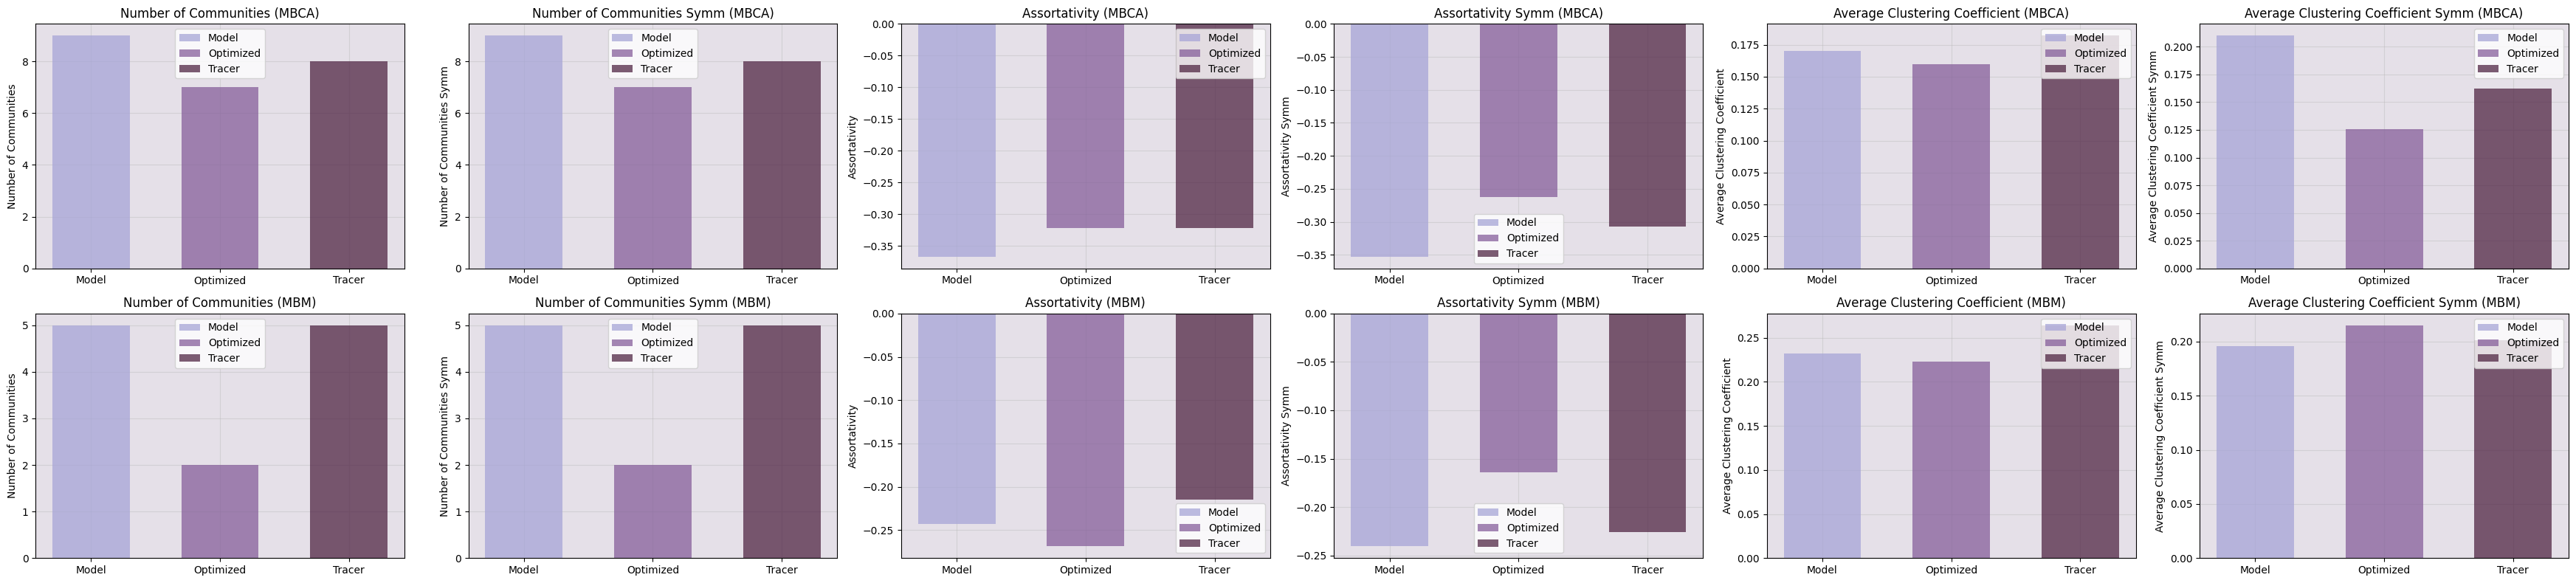

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Keep your style_plot function as-is:
def style_plot(ax, title, beige_color):
    ax.patch.set_facecolor(beige_color)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=alpha_grid)
    ax.set_axisbelow(True)

# Adjust the plot_mean_bar function:
def plot_mean_bar(ax, data, title, atlas):
    labels = ["Model", "Optimized", "Tracer"]
    
    model_value = data["Model"][atlas]
    optimized_value = data["Optimized"][atlas]
    tracer_value = data["Tracer"][atlas]
    
    values = [model_value, optimized_value, tracer_value]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    color_list = [pinkish, inbetween, purpleish]
    for k, (value, label, color) in enumerate(zip(values, labels, color_list)):
        ax.bar(x[k], value, width, color=color, alpha=alpha, label=label)

    ax.set_ylabel(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    style_plot(ax, "{} ({})".format(title, atlas), beige_color)

# Create the main figure and subplots:
fig, axs = plt.subplots(2, 6, figsize=(35, 8))

titles = ["Number of Communities", "Number of Communities Symm", "Assortativity", "Assortativity Symm", "Average Clustering Coefficient", "Average Clustering Coefficient Symm"]
atlases = ["MBCA", "MBM"]

for i, atlas in enumerate(atlases):
    for j, title in enumerate(titles):
        plot_mean_bar(axs[i, j], data_sets[title], title, atlas)

fig.tight_layout()
plt.show()


In [127]:
# Function to compute the minimum spanning tree
def compute_minimum_spanning_tree(graphs):

    # Create a dictionary
    minimum_spanning_tree = {}

    # Loop over each graph
    for atlas_name, graph in graphs.items():
        # Compute the minimum spanning tree
        minimum_spanning_tree[atlas_name] = nx.minimum_spanning_tree(graph, weight="weight")

    # Return the dictionary
    return minimum_spanning_tree

# Compute the stuff from the function above
model_minimum_spanning_tree = compute_minimum_spanning_tree(model_graphs)
optimized_minimum_spanning_tree = compute_minimum_spanning_tree(optimized_graphs)
tracer_minimum_spanning_tree = compute_minimum_spanning_tree(tracer_graphs)

# Compute the stuff from the function above - symmetrized
model_symm_minimum_spanning_tree = compute_minimum_spanning_tree(model_symm_graphs)
optimized_symm_minimum_spanning_tree = compute_minimum_spanning_tree(optimized_symm_graphs)
tracer_symm_minimum_spanning_tree = compute_minimum_spanning_tree(tracer_symm_graphs)

## **Visualization**

Length of nodal strength list: 135
Number of nodes in graph: 135


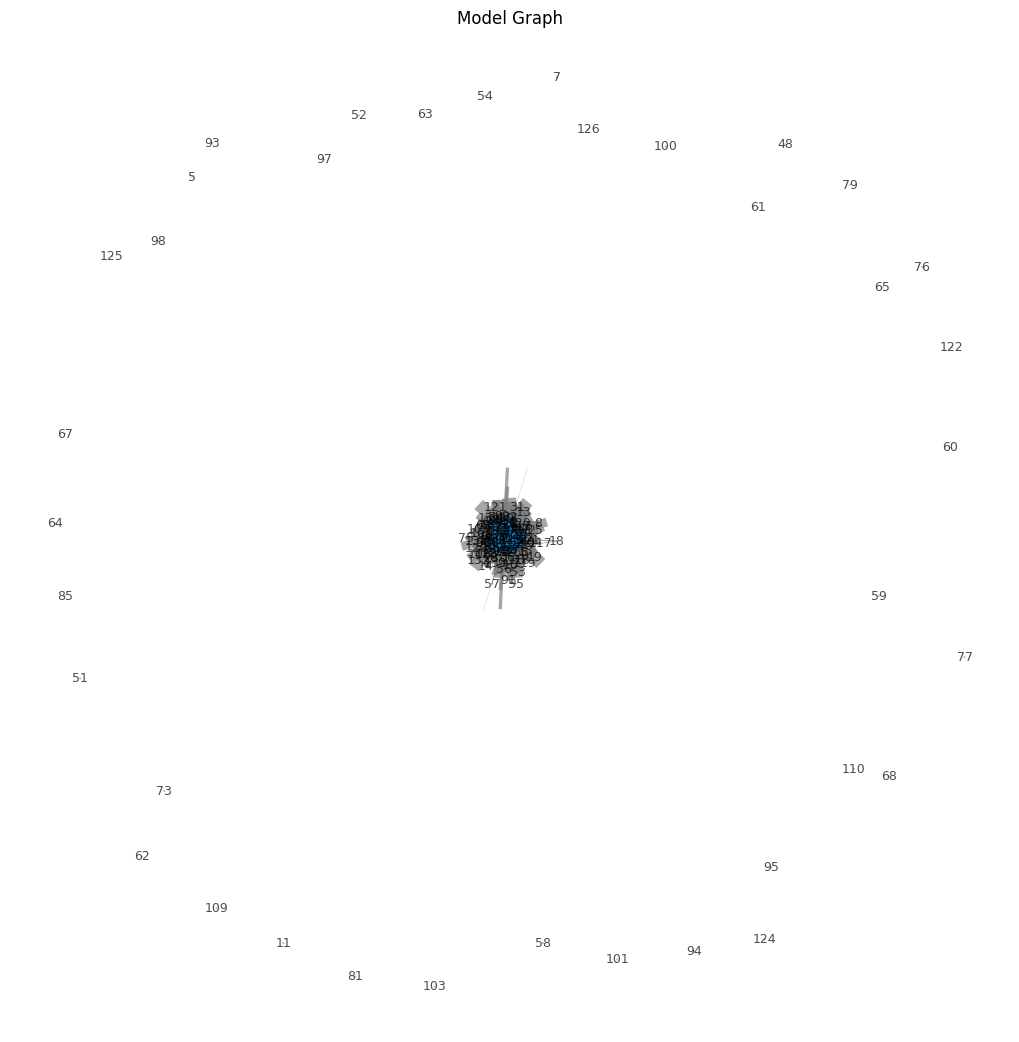

In [128]:
# Visualize network graph with nodes in proportion to their degree
def visualize_graph(graph, title, norm_strength):
    # Set the figure size
    plt.figure(figsize=(10, 10))
    # Draw the graph
    edgewidth = [ d['weight'] for (u,v,d) in graph.edges(data=True)]
    pos = nx.spring_layout(graph, scale=5)
    nx.draw(graph, pos, with_labels=True, width=np.power(edgewidth, 2), edge_color='grey', node_size=norm_strength, 
            font_color='black', cmap=plt.cm.Spectral, alpha=0.7, font_size=9)
    # Set the title
    plt.title(title)
    # Show the plot
    plt.show()

# Turn the normalized strength MBCA into a list from a numpy array
current_strength = model_nodal_normalized_strength["MBCA"].tolist()
min_size = 0.1  # This value can be adjusted based on your preferences
current_strength = [s if s > 0 else min_size for s in current_strength]
print("Length of nodal strength list:", len(current_strength))
print("Number of nodes in graph: {}".format(len(model_graphs["MBCA"])))

# Visualize the graphs
visualize_graph(model_graphs["MBCA"], "Model Graph", current_strength)
# visualize_graph(optimized_graphs["MBCA"], "Optimized Graph", optimized_nodal_normalized_strength["MBCA"])
# visualize_graph(tracer_graphs["MBCA"], "Tracer Graph", tracer_nodal_normalized_strength["MBCA"])

# # Visualize the graphs - symmetrized
# visualize_graph(model_symm_graphs["MBCA"], "Model Symmetrized Graph", model_symm_nodal_normalized_strength["MBCA"])
# visualize_graph(optimized_symm_graphs["MBCA"], "Optimized Symmetrized Graph", optimized_symm_nodal_normalized_strength["MBCA"])
# visualize_graph(tracer_symm_graphs["MBCA"], "Tracer Symmetrized Graph", tracer_symm_nodal_normalized_strength["MBCA"])

In [129]:
# Set the MBCA and MBM atlas labels as attributes for the nodes
nx.set_node_attributes(model_graphs["MBCA"], MBCA_label_data, "MBCA_label")
nx.set_node_attributes(model_graphs["MBM"], MBM_label_data, "MBM_label")

nx.set_node_attributes(optimized_graphs["MBCA"], MBCA_label_data, "MBCA_label")
nx.set_node_attributes(optimized_graphs["MBM"], MBM_label_data, "MBM_label")

nx.set_node_attributes(tracer_graphs["MBCA"], MBCA_label_data, "MBCA_label")
nx.set_node_attributes(tracer_graphs["MBM"], MBM_label_data, "MBM_label")

## **CircosPlot**

In [130]:
def chunk_dict(d, num_chunks):
    keys = list(d.keys())
    chunk_size = len(keys) // num_chunks
    chunks = []
    for i in range(0, len(keys), chunk_size):
        current_keys = keys[i:i+chunk_size]
        chunk = {int(key): d[key] for key in current_keys}
        chunks.append(chunk)
    return chunks

MBCA_categories = chunk_dict(MBCA_label_data, 11)
MBM_categories = chunk_dict(MBM_label_data, 10)

print("Number of MBCA categories: {}".format(len(MBCA_categories)))
print("Number of MBM categories: {}".format(len(MBM_categories)))

Number of MBCA categories: 12
Number of MBM categories: 11


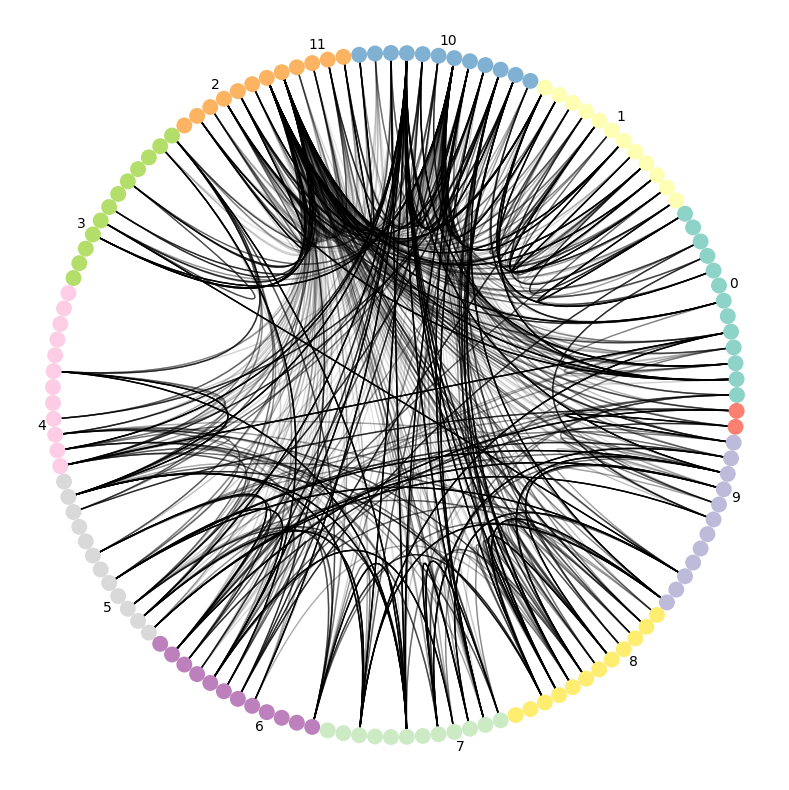

In [147]:
import nxviz as nv
from nxviz import annotate

# Create new dictionaries that will contain the graphs with the node labels
model_graphs_labeled = {}
optimized_graphs_labeled = {}
tracer_graphs_labeled = {}
model_symm_graphs_labeled = {}
optimized_symm_graphs_labeled = {}
tracer_symm_graphs_labeled = {}

# Function to assign a group to each node
def assign_group(graph, categories):

    # Copy the graph
    new_graph = graph.copy()
    
    # Create a dictionary to store the new 'group' attributes
    new_group_attributes = {}
    
    # For each node in the graph
    for node in new_graph.nodes():
        group_assigned = False

        # For each group in the categories
        for category_id, category_dict in enumerate(categories):
            # If the node is in the category
            if node in category_dict.keys():
                # Set the group in the new_group_attributes dictionary
                new_group_attributes[node] = str(category_id)
                group_assigned = True
                break  # Exit the loop if found

        # If the node did not get assigned to any group, assign a default value
        if not group_assigned:
            new_group_attributes[node] = '0'  # Default value

    # Override the 'group' attribute of all nodes in the graph using set_node_attributes
    nx.set_node_attributes(new_graph, new_group_attributes, 'group')

    return new_graph

# Label the graphs
model_graphs_labeled["MBCA"] = assign_group(model_graphs["MBCA"], MBCA_categories)
model_graphs_labeled["MBM"] = assign_group(model_graphs["MBM"], MBM_categories)
optimized_graphs_labeled["MBCA"] = assign_group(optimized_graphs["MBCA"], MBCA_categories)
optimized_graphs_labeled["MBM"] = assign_group(optimized_graphs["MBM"], MBM_categories)
tracer_graphs_labeled["MBCA"] = assign_group(tracer_graphs["MBCA"], MBCA_categories)
tracer_graphs_labeled["MBM"] = assign_group(tracer_graphs["MBM"], MBM_categories)

# Label the graphs - symmetrized
model_symm_graphs_labeled["MBCA"] = assign_group(model_symm_graphs["MBCA"], MBCA_categories)
model_symm_graphs_labeled["MBM"] = assign_group(model_symm_graphs["MBM"], MBM_categories)
optimized_symm_graphs_labeled["MBCA"] = assign_group(optimized_symm_graphs["MBCA"], MBCA_categories)
optimized_symm_graphs_labeled["MBM"] = assign_group(optimized_symm_graphs["MBM"], MBM_categories)
tracer_symm_graphs_labeled["MBCA"] = assign_group(tracer_symm_graphs["MBCA"], MBCA_categories)
tracer_symm_graphs_labeled["MBM"] = assign_group(tracer_symm_graphs["MBM"], MBM_categories)

# Draw a circus plot for the model graph
plt.figure(figsize=(10, 10))
nv.circos(model_graphs_labeled["MBCA"], node_color_by="group", edge_alpha_by="distance")
annotate.circos_group(model_graphs_labeled["MBCA"], group_by="group", midpoint=True)
plt.show()